# Adversarial Robustness - SVHN - Robustified Classifier via the Convex Outer Adversarial Polytope
---

In this notebook, two state-of-the-art CNNs of 4 convolutional layers prior to the fully-connected part (trained on the SVHN normally and robustly using the the "Convex Outer Adversarial Polytope" described in [Provable Defenses against Adversarial Examples via the Convex Outer Adversarial Polytope](https://arxiv.org/pdf/1711.00851.pdf) by Wong and Kolter) and their corresponding best accuracy distillated models go under the same series of adversarial attacks to compare their "out-of-the-box" adversarial robustness. The adversarial attacks are generated using cleverhans library [Technical Report on the cleverhans v2.1.0 Adversarial Examples Library](https://arxiv.org/pdf/1610.00768.pdf) by Papernot et al. The adversarial attacks tested: 

*   Projected Gradient Descent [Towards deep learning models resistant to adversarial attacks](https://arxiv.org/pdf/1706.06083.pdf) by Madry et al.

The distillated models have been generated using one of the following techniques:


*   "Matching the Logits" as it is described by Ba & Caruana on [Do Deep Nets Really Need to be Deep?](https://arxiv.org/pdf/1312.6184.pdf)
*   "Ranging the Teacher’s Temperature" as it is described by Hinton, Vinyals & Dean on [Distilling the Knowledge in a Neural Network](https://arxiv.org/pdf/1503.02531.pdf)
*   "Adversarial Distillation" as it is described by Goldblum, Fowl, Feizi & Goldstein on [Adversarially Robust Distillation](https://arxiv.org/pdf/1905.09747.pdf)




## Load the Neccesary Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
!pip install cleverhans

In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K
from keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from scipy.io import loadmat

Using TensorFlow backend.


In [ ]:
session = tf.Session()
session = tf.compat.v1.Session()
keras.backend.set_session(session)

## Attack Models

### Load Model and Data

In [ ]:
def get_CNN_model():
  #CNN network for classification
  svhn_model = models.Sequential(name='CNN')
  svhn_model.add(layers.Conv2D(16, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', input_shape=(3, 32, 32),  name='0'))
  svhn_model.add(layers.Conv2D(16, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', name='2'))
  svhn_model.add(layers.Conv2D(32, 4,  data_format='channels_first',activation='relu', strides = 2, padding='same', name='4'))
  svhn_model.add(layers.Conv2D(32, 4,  data_format='channels_first',activation='relu', strides = 2, padding='same', name='6'))
  svhn_model.add(Flatten(name='8'))
  svhn_model.add(layers.Dense(100, activation='relu', name='9'))
  svhn_model.add(layers.Dense(10, name='11'))
  return svhn_model

In [ ]:
def get_SCNN_model_layer2(channels_l1, channels_l2):
  #CNN network for classification
  svhn_model = models.Sequential(name='SCNN')
  svhn_model.add(layers.Conv2D(channels_l1, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', input_shape=(3, 32, 32),  name='0'))
  svhn_model.add(layers.Conv2D(channels_l2, 4, data_format='channels_first', activation='relu', strides = 2, padding='same', name='2'))
  svhn_model.add(Flatten(name='8'))
  svhn_model.add(layers.Dense(100, activation='relu', name='9'))
  svhn_model.add(layers.Dense(10, name="logit"))
  return svhn_model

In [ ]:
# Restore the data
y_acc_test=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/y_acc_test.npy')

x_acc_test_old=np.load('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/x_acc_test_cnn.npy')
x_acc_test=[]
for i in range(26032):
  test = x_acc_test_old[i,:,:,:].T
  test_new = []
  for j in range(3):
    test_new.append(test[j].T)
  x_acc_test.append(np.array(test_new))
x_acc_test_cnn = np.array(x_acc_test)

### Define the PGD Attacks

In [ ]:
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import ProjectedGradientDescent

def pgd_attack(svhn_model, epsilon):
  wrap = KerasModelWrapper(svhn_model)
  pgd = ProjectedGradientDescent(wrap, sess=session)

  pgd_params = {'eps': epsilon,
                'eps_iter': 0.5*epsilon,
                'nb_iter': 100,
                'clip_min': 0.,
                'clip_max': 1.}

  adv_x = pgd.generate_np(x_acc_test_cnn, **pgd_params)
  score, adv_acc = svhn_model.evaluate(adv_x, y_acc_test, batch_size=128)
  print("The PGD validation accuracy is: {}".format(adv_acc))
  return score, adv_acc

### Projected Gradient Descent

#### Baseline & Robust (Teacher)

In [ ]:
epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

# Load the model and wrap the network
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/Baseline_Keras.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Baseline:')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

###########################################

epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

# Load the model and wrap the network
svhn_model = get_CNN_model()
svhn_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/SVHN/robust_convex/Robust_Keras.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Robust at 0.01:')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

#### Adversarially Distillated using Teacher's architecture to generate the Adversarial Examples

In [ ]:
epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

svhn_model = get_SCNN_model_layer2(32, 128)
svhn_model = keras.models.load_model('/content/drive/My Drive/SCNN_MIMIC_SVHN_h32_128.h5')

output = svhn_model.layers[-1].output
output = Activation('softmax')(output)
svhn_model = Model(svhn_model.input, output, name='SCNN')
svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Robustly Distillated :')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

#### Adversarially Distillated using Student's architecture to generate the Adversarial Examples

In [ ]:
epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

svhn_model = get_SCNN_model_layer2(16, 32)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h16_32.h5')

output = svhn_model.layers[-1].output
output = Activation('softmax')(output)
svhn_model = Model(svhn_model.input, output, name='SCNN')
svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Robustly Distillated :')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

#### Adversarially Distillated using Student's architecture to generate the Adversarial Examples On-The-Fly

In [ ]:
epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

svhn_model = get_SCNN_model_layer2(16, 32)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h16_32.h5')

output = svhn_model.layers[-1].output
output = Activation('softmax')(output)
svhn_model = Model(svhn_model.input, output, name='SCNN')
svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Robustly Distillated :')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

#### Robust Retrained

In [ ]:
epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

svhn_model = get_SCNN_model_layer2(16, 32)
svhn_model = keras.models.load_model('/content/Robust_ReTrain_Keras.h5')
svhn_model.add(layers.Activation('softmax'))
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Robust Temperature ReTrained at 0.01:')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

#### Robust Distillated using Teacher's Temperature

In [ ]:
epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

# Load the model and wrap the network
svhn_model = get_SCNN_model_layer2(32, 128)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h32_128_0.1_new_impr.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Robust Temperature Impr at 0.01:')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

#########

svhn_model = get_SCNN_model_layer2(32, 128)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h32_128_0.1_new_same.h5')
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Robust Temperature Same at 0.01:')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

In [ ]:
epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

# Load the model and wrap the network
svhn_model = get_SCNN_model_layer2(32, 128)
svhn_model = keras.models.load_model('/content/SCNN_MIMIC_SVHN_h32_128_0.1.h5')
svhn_model.add(layers.Activation('softmax'))
score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Robust Temperature at 0.01:')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

#### Baseline & Robust (Student - Pruned)

In [ ]:
epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

# Load the model and wrap the network
svhn_model = get_SCNN_model_layer2(16, 64)
svhn_model = keras.models.load_model('/content/drive/My Drive/SCNN_MIMIC_SVHN_h16_64_new.h5')

output = svhn_model.layers[-1].output
output = Activation('softmax')(output)
svhn_model = Model(svhn_model.input, output, name='SCNN')
svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Baseline Distillated:')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

###########################################

epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

# Load the model and wrap the network
svhn_model = get_SCNN_model_layer2(16, 32)
svhn_model = keras.models.load_model('/content/drive/My Drive/SCNN_MIMIC_SVHN_h16_32_new.h5')

output = svhn_model.layers[-1].output
output = Activation('softmax')(output)
svhn_model = Model(svhn_model.input, output, name='SCNN')
svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Robust at 0.01 Distillated:')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

#### Baseline-78 (Teacher & Student)

In [ ]:
epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

# Load the model and wrap the network
svhn_model = get_SCNN_model_layer2(32, 128)
svhn_model = keras.models.load_model('/content/drive/My Drive/SCNN_MIMIC_SVHN_32_128.h5')

output = svhn_model.layers[-1].output
output = Activation('softmax')(output)
svhn_model = Model(svhn_model.input, output, name='SCNN')
svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Baseline-78:')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

###########################################

epsilon_accuracies_teacher_pgd = []
epsilon_values_teacher_pgd  = []

# Load the model and wrap the network
svhn_model = get_SCNN_model_layer2(32, 128)
svhn_model = keras.models.load_model('/content/drive/My Drive/SCNN_MIMIC_SVHN_32_128_new.h5')

output = svhn_model.layers[-1].output
output = Activation('softmax')(output)
svhn_model = Model(svhn_model.input, output, name='SCNN')
svhn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

score, acc = svhn_model.evaluate(x_acc_test_cnn, y_acc_test, batch_size=128)
print ("Test Accuracy: %.5f" % acc)

score, adv_acc = pgd_attack(svhn_model, 0.01)
print ("0.01 acc:" + str(adv_acc))

for epsilon in np.arange(0.0, 0.1, 0.001):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

for epsilon in np.arange(0.1, 0.3, 0.1):
  score, adv_acc = pgd_attack(svhn_model, epsilon)
  epsilon_accuracies_teacher_pgd.append(adv_acc)
  epsilon_values_teacher_pgd.append(epsilon)

plt.xlabel('Epsilon');
plt.ylabel('Accuracy After Attack');
plt.plot(epsilon_values_teacher_pgd, epsilon_accuracies_teacher_pgd)

print ('Baseline-78 Distillated:')
print (epsilon_accuracies_teacher_pgd)
print (epsilon_values_teacher_pgd)

## Results

In [ ]:
epsilon_values = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.011, 0.012, 0.013000000000000001, 0.014, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026000000000000002, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043000000000000003, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051000000000000004, 0.052000000000000005, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059000000000000004, 0.06, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.07100000000000001, 0.07200000000000001, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08, 0.081, 0.082, 0.083, 0.084, 0.085, 0.08600000000000001, 0.08700000000000001, 0.088, 0.089, 0.09, 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099, 0.1, 0.2]

#Baseline:
baseline=[0.8595958948135376, 0.8448832035064697, 0.8073140978813171, 0.7529194951057434, 0.688921332359314, 0.6205823421478271, 0.5494391322135925, 0.48501843214035034, 0.42563000321388245, 0.3730408847332001, 0.322795033454895, 0.28203749656677246, 0.24907806515693665, 0.2185003012418747, 0.19326214492321014, 0.1726720929145813, 0.15538567304611206, 0.13955900073051453, 0.12676705420017242, 0.11505070328712463, 0.10537031292915344, 0.09668868780136108, 0.09054240584373474, 0.08527965843677521, 0.0813998132944107, 0.07744314521551132, 0.07444683462381363, 0.07033650577068329, 0.06803165376186371, 0.06707129627466202, 0.06461278349161148, 0.06399815529584885, 0.061962202191352844, 0.06153964251279831, 0.061001844704151154, 0.06004148721694946, 0.06023355945944786, 0.05850491672754288, 0.056661032140254974, 0.05719883367419243, 0.05689151957631111, 0.05673786252737045, 0.05646895989775658, 0.05627689138054848, 0.055316533893346786, 0.055431775748729706, 0.055508606135845184, 0.05477873235940933, 0.0539720356464386, 0.053357407450675964, 0.05385679006576538, 0.05366472154855728, 0.05289643630385399, 0.053318992257118225, 0.052243392914533615, 0.05258912220597267, 0.05308850482106209, 0.052473876625299454, 0.05266594886779785, 0.051244620233774185, 0.052358634769916534, 0.05178242176771164, 0.05162876471877098, 0.051129378378391266, 0.05051475018262863, 0.052128151059150696, 0.05039950832724571, 0.051321450620889664, 0.050207436084747314, 0.05036109313368797, 0.0497080534696579, 0.05051475018262863, 0.04863245412707329, 0.05028426647186279, 0.049093425273895264, 0.04940073937177658, 0.04847879707813263, 0.04936232417821884, 0.04863245412707329, 0.04832514002919197, 0.04824830964207649, 0.047979410737752914, 0.04778733849525452, 0.04836355149745941, 0.04713429510593414, 0.04771051183342934, 0.04759526625275612, 0.04705746844410896, 0.04740319773554802, 0.04640442505478859, 0.046980638056993484, 0.047019053250551224, 0.04644284024834633, 0.045674555003643036, 0.04555931314826012, 0.04740319773554802, 0.04628918319940567, 0.046942226588726044, 0.04628918319940567, 0.044867854565382004, 0.04636600986123085, 0.0348801463842392]

#Robust at 0.01:
robust=[0.7422019243240356, 0.74131840467453, 0.7401659488677979, 0.7361324429512024, 0.7305623888969421, 0.7228411436080933, 0.7134296298027039, 0.7024815678596497, 0.6923018097877502, 0.679893970489502, 0.6667947173118591, 0.6537338495254517, 0.6409419178962708, 0.6240780353546143, 0.6104794144630432, 0.5940765142440796, 0.5798632502555847, 0.5647280216217041, 0.5488629341125488, 0.5331898927688599, 0.5188997983932495, 0.5033036470413208, 0.4871312379837036, 0.47145819664001465, 0.4576674997806549, 0.4424554407596588, 0.4272433817386627, 0.412415474653244, 0.3983558714389801, 0.38571757078170776, 0.37234941124916077, 0.3605562448501587, 0.3476490378379822, 0.3343192934989929, 0.3224877119064331, 0.31061771512031555, 0.30055317282676697, 0.2892209589481354, 0.27919483184814453, 0.26951444149017334, 0.260295033454895, 0.2508835196495056, 0.24193300306797028, 0.23163798451423645, 0.22245697677135468, 0.21527351438999176, 0.2097034454345703, 0.2011754810810089, 0.19410724937915802, 0.1866164654493332, 0.18093116581439972, 0.17447756230831146, 0.16798555850982666, 0.16218499839305878, 0.15738321840763092, 0.15215888619422913, 0.14789490401744843, 0.1426321417093277, 0.13733097910881042, 0.13483405113220215, 0.13057006895542145, 0.12453903257846832, 0.12188844382762909, 0.1188921332359314, 0.11547326296567917, 0.11312999576330185, 0.10932698100805283, 0.10583128780126572, 0.10287338495254517, 0.10187461227178574, 0.09945451468229294, 0.09653503447771072, 0.0945759043097496, 0.09173325449228287, 0.09084971994161606, 0.08892901241779327, 0.08743085712194443, 0.08612477034330368, 0.08462661504745483, 0.08247541636228561, 0.08047787100076675, 0.07951751351356506, 0.07863398641347885, 0.07813460379838943, 0.07759680598974228, 0.07617547363042831, 0.07448524981737137, 0.07356330752372742, 0.07225722074508667, 0.07164259254932404, 0.07087431102991104, 0.06929932534694672, 0.06887676566839218, 0.06741702556610107, 0.06668715178966522, 0.06687922775745392, 0.06549631059169769, 0.0641518160700798, 0.06353718787431717, 0.06430546939373016, 0.06346035748720169, 0.04659649729728699]

#Baseline Distillated:
baseline_distill=[0.8660110831260681, 0.8496465682983398, 0.8139597177505493, 0.759181022644043, 0.6926859021186829, 0.6236554980278015, 0.5544714331626892, 0.4865550100803375, 0.4252074360847473, 0.368507981300354, 0.3184926211833954, 0.2778119146823883, 0.2421634942293167, 0.21154733002185822, 0.18415795266628265, 0.16383682191371918, 0.14551322162151337, 0.1301475167274475, 0.11862323433160782, 0.10867393761873245, 0.09887830168008804, 0.0906960666179657, 0.08577904105186462, 0.08109249919652939, 0.07659803330898285, 0.07337123900651932, 0.07025968283414841, 0.06830055266618729, 0.06576520949602127, 0.06369084119796753, 0.06284572929143906, 0.06146281585097313, 0.05996466055512428, 0.059926245361566544, 0.058927472680807114, 0.05796711891889572, 0.057506147772073746, 0.05708358809351921, 0.05846650153398514, 0.05646895989775658, 0.056507375091314316, 0.0558159202337265, 0.05566226318478584, 0.0558159202337265, 0.05516287684440613, 0.05616164579987526, 0.05470190569758415, 0.05474032089114189, 0.05470190569758415, 0.05474032089114189, 0.05431776121258736, 0.05477873235940933, 0.05393362045288086, 0.053434234112501144, 0.05305009335279465, 0.05274277925491333, 0.0541641041636467, 0.053318992257118225, 0.053280577063560486, 0.053549475967884064, 0.05274277925491333, 0.052397049963474274, 0.05305009335279465, 0.051167793571949005, 0.05182083696126938, 0.0517440065741539, 0.05251229181885719, 0.05028426647186279, 0.04966963827610016, 0.05089889466762543, 0.05151352286338806, 0.05066840723156929, 0.04993853718042374, 0.050053779035806656, 0.05043792352080345, 0.05055316537618637, 0.0493239089846611, 0.050245851278305054, 0.04874769598245621, 0.04832514002919197, 0.049016594886779785, 0.048056237399578094, 0.04724954068660736, 0.04878611117601395, 0.04736478254199028, 0.04817148298025131, 0.046750154346227646, 0.04966963827610016, 0.04855562373995781, 0.04828672483563423, 0.04705746844410896, 0.04751843959093094, 0.04651966691017151, 0.04763368144631386, 0.047979410737752914, 0.04721112549304962, 0.04763368144631386, 0.046903811395168304, 0.04648125544190407, 0.04659649729728699, 0.04644284024834633, 0.03445759043097496]

#Robust at 0.01 Distillated:
robust_distill=[0.7458896636962891, 0.7417024970054626, 0.726874589920044, 0.7061309218406677, 0.6804317831993103, 0.6521973013877869, 0.6178933382034302, 0.5850107669830322, 0.5490165948867798, 0.5149431228637695, 0.48017823696136475, 0.44483712315559387, 0.4105716049671173, 0.3811846971511841, 0.351336807012558, 0.32340964674949646, 0.29655808210372925, 0.271127849817276, 0.24953903257846832, 0.2292563021183014, 0.2097034454345703, 0.19257068634033203, 0.17651352286338806, 0.162300243973732, 0.15123693645000458, 0.14082667231559753, 0.13103103637695312, 0.12234941869974136, 0.11458973586559296, 0.10821297019720078, 0.10206668823957443, 0.09584357589483261, 0.09315457940101624, 0.08877535164356232, 0.08543331176042557, 0.08289796859025955, 0.0801321417093277, 0.07859557121992111, 0.07613705843687057, 0.0749078094959259, 0.07260295003652573, 0.07148893922567368, 0.07091272622346878, 0.07033650577068329, 0.06903042644262314, 0.06845421344041824, 0.06891518086194992, 0.06687922775745392, 0.06649508327245712, 0.0651121661067009, 0.0661877691745758, 0.06564997136592865, 0.06572679430246353, 0.06476644426584244, 0.06384450197219849, 0.06426705420017242, 0.06322987377643585, 0.06330669671297073, 0.06284572929143906, 0.0628841444849968, 0.0623079277575016, 0.06253841519355774, 0.0623079277575016, 0.06153964251279831, 0.06146281585097313, 0.06142440065741539, 0.06138598546385765, 0.062077444046735764, 0.061001844704151154, 0.06038721650838852, 0.060694530606269836, 0.06161647289991379, 0.05846650153398514, 0.059772588312625885, 0.059657346457242966, 0.06111708655953407, 0.05911954492330551, 0.06054087355732918, 0.05796711891889572, 0.058696988970041275, 0.058850646018981934, 0.05923478677868843, 0.05996466055512428, 0.05908112972974777, 0.059849414974451065, 0.05850491672754288, 0.05900430306792259, 0.05781346186995506, 0.05846650153398514, 0.058696988970041275, 0.058850646018981934, 0.05808236077427864, 0.05815918743610382, 0.057698216289281845, 0.05723724514245987, 0.05800553038716316, 0.057736631482839584, 0.057851873338222504, 0.05808236077427864, 0.05827443301677704, 0.05719883367419243, 0.046750154346227646]

#Baseline-78 :
base78 = [0.7816917896270752, 0.7730485796928406, 0.7516902089118958, 0.7209588289260864, 0.6823909282684326, 0.6366779208183289, 0.5911954641342163, 0.5467885732650757, 0.5, 0.45636141300201416, 0.41514289379119873, 0.3783804476261139, 0.3427320122718811, 0.31004148721694946, 0.28134602308273315, 0.2559926211833954, 0.23348186910152435, 0.21277658641338348, 0.19575907289981842, 0.18127688765525818, 0.16648739576339722, 0.1543484926223755, 0.1440918892621994, 0.1339121013879776, 0.12553779780864716, 0.11931469291448593, 0.11343730986118317, 0.10706054419279099, 0.10222034156322479, 0.0971880778670311, 0.09288568049669266, 0.0908881351351738, 0.08773817121982574, 0.08485709875822067, 0.08355101197957993, 0.0812077447772026, 0.07886447757482529, 0.07775045931339264, 0.07556084543466568, 0.07390903681516647, 0.07321757823228836, 0.07248770445585251, 0.07129686325788498, 0.06972187757492065, 0.06922249495983124, 0.06830055266618729, 0.06741702556610107, 0.06584203988313675, 0.0661877691745758, 0.06603410840034485, 0.06499692797660828, 0.06484326720237732, 0.0643438845872879, 0.06426705420017242, 0.06334511190652847, 0.06357559561729431, 0.0626920685172081, 0.06234634295105934, 0.06330669671297073, 0.06226951628923416, 0.061885371804237366, 0.060925014317035675, 0.062039028853178024, 0.06115550175309181, 0.060886602848768234, 0.060771357268095016, 0.06104025989770889, 0.0606561154127121, 0.06050245836377144, 0.05946527421474457, 0.0584280900657177, 0.060694530606269836, 0.05923478677868843, 0.05950368940830231, 0.05954210087656975, 0.058735404163599014, 0.05904271826148033, 0.057698216289281845, 0.05915796011686325, 0.05846650153398514, 0.057736631482839584, 0.05735249072313309, 0.05716041848063469, 0.05742931738495827, 0.056200060993433, 0.05612323433160782, 0.05635371804237366, 0.05646895989775658, 0.056545790284872055, 0.055508606135845184, 0.05504763498902321, 0.05635371804237366, 0.056699447333812714, 0.05493238940834999, 0.0558159202337265, 0.055547017604112625, 0.05523970350623131, 0.05623847618699074, 0.055316533893346786, 0.054279349744319916, 0.0537799634039402, 0.04383067041635513]

#Baseline-78 Distillated:
base78_distill=[0.7927935123443604, 0.7840734720230103, 0.7566840648651123, 0.7137753367424011, 0.6666794419288635, 0.6155501008033752, 0.5601951479911804, 0.5086047649383545, 0.45809003710746765, 0.41187769174575806, 0.36739397048950195, 0.32832667231559753, 0.29267823696136475, 0.26186999678611755, 0.23513367772102356, 0.21120159327983856, 0.18965119123458862, 0.17359404265880585, 0.1583435833454132, 0.14493699371814728, 0.13414259254932404, 0.12515366077423096, 0.1166641041636467, 0.10928856581449509, 0.10325752943754196, 0.09722649306058884, 0.09261678159236908, 0.08912108093500137, 0.0862400159239769, 0.08285956084728241, 0.08009373396635056, 0.07821143418550491, 0.07517670840024948, 0.07410110533237457, 0.07237246632575989, 0.0716041773557663, 0.07037492096424103, 0.06891518086194992, 0.06949139386415482, 0.06791640818119049, 0.06680239737033844, 0.06718654185533524, 0.06641825288534164, 0.06645666807889938, 0.06480485200881958, 0.06507375836372375, 0.0647280290722847, 0.06445913016796112, 0.06438229978084564, 0.06399815529584885, 0.06384450197219849, 0.06342194229364395, 0.06223110109567642, 0.06223110109567642, 0.06226951628923416, 0.06246158480644226, 0.06261524558067322, 0.062000613659620285, 0.06153964251279831, 0.060886602848768234, 0.062039028853178024, 0.06034880131483078, 0.060925014317035675, 0.059772588312625885, 0.06050245836377144, 0.06054087355732918, 0.05938844382762909, 0.06057928875088692, 0.06004148721694946, 0.058696988970041275, 0.058773815631866455, 0.05850491672754288, 0.058581747114658356, 0.05800553038716316, 0.05792870372533798, 0.05919637531042099, 0.057544559240341187, 0.05808236077427864, 0.05704517662525177, 0.05696834623813629, 0.05635371804237366, 0.05704517662525177, 0.05719883367419243, 0.0560079887509346, 0.05589274689555168, 0.057736631482839584, 0.055470190942287445, 0.05589274689555168, 0.05504763498902321, 0.054433006793260574, 0.055623847991228104, 0.05523970350623131, 0.055316533893346786, 0.055508606135845184, 0.054548248648643494, 0.05404886230826378, 0.053472649306058884, 0.053280577063560486, 0.054471418261528015, 0.05401044711470604, 0.054471418261528015, 0.04071911424398422]

# Robust Temperature:
robust_distill_temp_impr = [0.7506530284881592, 0.748732328414917, 0.7375537753105164, 0.7187308073043823, 0.6966041922569275, 0.6704056262969971, 0.6448985934257507, 0.6163952350616455, 0.5893515944480896, 0.5615012049674988, 0.5313076376914978, 0.5028042197227478, 0.4755685329437256, 0.4495236575603485, 0.42428550124168396, 0.39839428663253784, 0.3741164803504944, 0.35314229130744934, 0.3334357738494873, 0.3161877691745758, 0.2974800169467926, 0.2810003161430359, 0.2654809355735779, 0.24953903257846832, 0.23601721227169037, 0.2249923199415207, 0.21262292563915253, 0.20190533995628357, 0.1910725235939026, 0.18262138962745667, 0.17463122308254242, 0.16748617589473724, 0.16164720058441162, 0.15527044236660004, 0.15016134083271027, 0.14470651745796204, 0.13967424631118774, 0.13598647713661194, 0.1344883292913437, 0.1301475167274475, 0.12692071497440338, 0.1246158555150032, 0.12208051979541779, 0.12008297443389893, 0.11716349422931671, 0.11616472154855728, 0.11458973586559296, 0.11293791979551315, 0.11070989817380905, 0.11044099926948547, 0.10844345390796661, 0.10871235281229019, 0.10744468122720718, 0.10560079663991928, 0.10502458363771439, 0.10414105653762817, 0.10464043915271759, 0.10268131643533707, 0.10325752943754196, 0.10256607085466385, 0.10248924046754837, 0.10160571336746216, 0.10210510343313217, 0.09891671687364578, 0.09937769174575806, 0.09953134506940842, 0.10053011775016785, 0.10022280365228653, 0.09945451468229294, 0.0984557494521141, 0.09795635938644409, 0.09876306354999542, 0.09807160496711731, 0.09776429086923599, 0.09634296596050262, 0.09811002016067505, 0.09668868780136108, 0.09853257238864899, 0.09645820409059525, 0.09745697677135468, 0.09668868780136108, 0.0973801463842392, 0.09772587567567825, 0.09665028005838394, 0.09484480321407318, 0.09511370956897736, 0.09503687918186188, 0.09592040628194809, 0.09588199108839035, 0.09426859021186829, 0.09542102366685867, 0.09615088999271393, 0.09361554682254791, 0.09350030869245529, 0.09469114989042282, 0.09469114989042282, 0.09446066617965698, 0.09346189349889755, 0.09300091862678528, 0.09350030869245529, 0.09315457940101624, 0.08024738729000092]

# ReTrained
robust_distill_retrained = [0.7842271327972412, 0.7828441858291626, 0.7801551818847656, 0.7763521671295166, 0.7696681022644043, 0.7623693943023682, 0.7536109685897827, 0.743661642074585, 0.7336355447769165, 0.7210740447044373, 0.7099339365959167, 0.6956438422203064, 0.6803933382034302, 0.664566695690155, 0.6491625905036926, 0.6316840648651123, 0.615050733089447, 0.5976490378379822, 0.5811309218406677, 0.5638060569763184, 0.5478641390800476, 0.5308082103729248, 0.513752281665802, 0.49773356318473816, 0.48156115412712097, 0.46554240584373474, 0.44910112023353577, 0.43385064601898193, 0.41760140657424927, 0.4025046229362488, 0.38571757078170776, 0.37088966369628906, 0.35683006048202515, 0.3437308073043823, 0.33109250664711, 0.3190688490867615, 0.30692994594573975, 0.2932160496711731, 0.28192225098609924, 0.2689766585826874, 0.2575676143169403, 0.24800245463848114, 0.23755377531051636, 0.22783496975898743, 0.21857713162899017, 0.20878149569034576, 0.199600487947464, 0.19072680175304413, 0.18281346559524536, 0.17628303170204163, 0.1686001867055893, 0.16383682191371918, 0.15692225098609924, 0.15131376683712006, 0.1467040628194809, 0.14144130051136017, 0.136831596493721, 0.13164566457271576, 0.12749692797660828, 0.12196527421474457, 0.11827750504016876, 0.11474338918924332, 0.11021050810813904, 0.10683005303144455, 0.10302704572677612, 0.10152889043092728, 0.09761063009500504, 0.09572833776473999, 0.09461431950330734, 0.09015826880931854, 0.08877535164356232, 0.0860479399561882, 0.08282114565372467, 0.08193761855363846, 0.0805162861943245, 0.0779041200876236, 0.07686693221330643, 0.0754840224981308, 0.07348647713661194, 0.07264136523008347, 0.07110479474067688, 0.06941456347703934, 0.06964505463838577, 0.06849262118339539, 0.0671481266617775, 0.06649508327245712, 0.06476644426584244, 0.06395974010229111, 0.06319145858287811, 0.0630762130022049, 0.0623079277575016, 0.061001844704151154, 0.06153964251279831, 0.06050245836377144, 0.059695757925510406, 0.05911954492330551, 0.058773815631866455, 0.05739090219140053, 0.05719883367419243, 0.05616164579987526, 0.05589274689555168, 0.0411800853908062]

# Adversarially Distillated with Robust Logits - Teacher
adv_distillated=[0.7467731833457947, 0.7214966416358948, 0.6632605791091919, 0.5835509896278381, 0.49869391322135925, 0.4158727824687958, 0.34046557545661926, 0.2779271602630615, 0.22579900920391083, 0.18561770021915436, 0.15254302322864532, 0.12853410840034485, 0.11113245040178299, 0.09803318977355957, 0.08704671263694763, 0.08028580248355865, 0.07390903681516647, 0.07114320993423462, 0.06818530708551407, 0.0653042420744896, 0.06442071497440338, 0.06365242600440979, 0.062154270708560944, 0.060809772461652756, 0.060963429510593414, 0.059811003506183624, 0.059618931263685226, 0.05908112972974777, 0.059695757925510406, 0.05781346186995506, 0.05827443301677704, 0.05815918743610382, 0.05700676143169403, 0.05727566033601761, 0.05704517662525177, 0.05612323433160782, 0.0558159202337265, 0.055354949086904526, 0.055316533893346786, 0.05493238940834999, 0.05523970350623131, 0.05516287684440613, 0.0541641041636467, 0.054625075310468674, 0.05497080460190773, 0.05366472154855728, 0.05500921979546547, 0.05351106449961662, 0.05297326296567917, 0.053318992257118225, 0.05312692001461983, 0.05274277925491333, 0.052320219576358795, 0.05270436406135559, 0.05266594886779785, 0.052358634769916534, 0.051398277282714844, 0.052320219576358795, 0.05178242176771164, 0.051206208765506744, 0.05159034952521324, 0.05062999203801155, 0.05036109313368797, 0.05086047947406769, 0.05162876471877098, 0.049900121986866, 0.049976952373981476, 0.05047633498907089, 0.04982329532504082, 0.05062999203801155, 0.05001536384224892, 0.049131836742162704, 0.04855562373995781, 0.047902580350637436, 0.04963122308254242, 0.047902580350637436, 0.04920866712927818, 0.04947756603360176, 0.04778733849525452, 0.04840196669101715, 0.04759526625275612, 0.04844038188457489, 0.04648125544190407, 0.04663491249084473, 0.04717271029949188, 0.045828212052583694, 0.047864168882369995, 0.04721112549304962, 0.046865396201610565, 0.045905038714408875, 0.04813306778669357, 0.044714197516441345, 0.04602028429508209, 0.04640442505478859, 0.04736478254199028, 0.04617394134402275, 0.04409956932067871, 0.04636600986123085, 0.045674555003643036, 0.0454440675675869, 0.04609711095690727, 0.03668561950325966]

# Adversarially Distillated with Robust Logits- Student
#adv_distillated_student =[0.7470421195030212, 0.734634280204773, 0.6994852423667908, 0.6498924493789673, 0.5908113121986389, 0.5301551818847656, 0.4727642834186554, 0.412415474653244, 0.36021050810813904, 0.3131914436817169, 0.2679010331630707, 0.2317916452884674, 0.20071449875831604, 0.17340196669101715, 0.1505838930606842, 0.13360479474067688, 0.11935310065746307, 0.10798248648643494, 0.09803318977355957, 0.08973570913076401, 0.08355101197957993, 0.0780961886048317, 0.07413952052593231, 0.07202673703432083, 0.06853103637695312, 0.06576520949602127, 0.06395974010229111, 0.06142440065741539, 0.060963429510593414, 0.05950368940830231, 0.05931161716580391, 0.057544559240341187, 0.05727566033601761, 0.057736631482839584, 0.05623847618699074, 0.056699447333812714, 0.05512446165084839, 0.05566226318478584, 0.055431775748729706, 0.054356176406145096, 0.05497080460190773, 0.05485556274652481, 0.05389520525932312, 0.05408727750182152, 0.053395818918943405, 0.0537799634039402, 0.05262753367424011, 0.05255070701241493, 0.05289643630385399, 0.05101413652300835, 0.0515519343316555, 0.052204977720975876, 0.051244620233774185, 0.05055316537618637, 0.05082206428050995, 0.05251229181885719, 0.05074523761868477, 0.05028426647186279, 0.05086047947406769, 0.050130609422922134, 0.04920866712927818, 0.05043792352080345, 0.05059158056974411, 0.04847879707813263, 0.048094652593135834, 0.04836355149745941, 0.04943915084004402, 0.0493239089846611, 0.049093425273895264, 0.04751843959093094, 0.048939768224954605, 0.04878611117601395, 0.04721112549304962, 0.04870928078889847, 0.04755685478448868, 0.04820989444851875, 0.04705746844410896, 0.04759526625275612, 0.04636600986123085, 0.04744160920381546, 0.047864168882369995, 0.0472879521548748, 0.04721112549304962, 0.04636600986123085, 0.04671173915266991, 0.045789796859025955, 0.045674555003643036, 0.04851720854640007, 0.04636600986123085, 0.04671173915266991, 0.045751381665468216, 0.04655808210372925, 0.04536724090576172, 0.046903811395168304, 0.04659649729728699, 0.045866627246141434, 0.044637370854616165, 0.04509834200143814, 0.044791027903556824, 0.04494468495249748, 0.04440688341856003, 0.037223417311906815]
adv_distillated_student =[0.7470421195030212, 0.7345574498176575, 0.6991779208183289, 0.6497771739959717, 0.5910418033599854, 0.5300783514976501, 0.47280269861221313, 0.4133758544921875, 0.3597879409790039, 0.31296098232269287, 0.2680162787437439, 0.23248310387134552, 0.19956207275390625, 0.17340196669101715, 0.15035341680049896, 0.13368162512779236, 0.11854640394449234, 0.1071757823228836, 0.09761063009500504, 0.08981253951787949, 0.08328211307525635, 0.07894130051136017, 0.07425476610660553, 0.07049016654491425, 0.06818530708551407, 0.0659957006573677, 0.06395974010229111, 0.06299938261508942, 0.060925014317035675, 0.05946527421474457, 0.058620158582925797, 0.05792870372533798, 0.057467732578516006, 0.057659804821014404, 0.05708358809351921, 0.05631530284881592, 0.05527811869978905, 0.056430548429489136, 0.05589274689555168, 0.05635371804237366, 0.054394591599702835, 0.0537799634039402, 0.05520129203796387, 0.0541641041636467, 0.052128151059150696, 0.052358634769916534, 0.053280577063560486, 0.05289643630385399, 0.0515519343316555, 0.05285802111029625, 0.052473876625299454, 0.0519360788166523, 0.05097572132945061, 0.05078364908695221, 0.051052551716566086, 0.04943915084004402, 0.05151352286338806, 0.05082206428050995, 0.05001536384224892, 0.05147510766983032, 0.050245851278305054, 0.04982329532504082, 0.049976952373981476, 0.049170251935720444, 0.05055316537618637, 0.049131836742162704, 0.04886293783783913, 0.04878611117601395, 0.047825753688812256, 0.0474800243973732, 0.0493239089846611, 0.04813306778669357, 0.04817148298025131, 0.04817148298025131, 0.04817148298025131, 0.04671173915266991, 0.04751843959093094, 0.0470958836376667, 0.047825753688812256, 0.0472879521548748, 0.04659649729728699, 0.046750154346227646, 0.04628918319940567, 0.045789796859025955, 0.045712970197200775, 0.045712970197200775, 0.04644284024834633, 0.04621235281229019, 0.04602028429508209, 0.046980638056993484, 0.045789796859025955, 0.0470958836376667, 0.04402274265885353, 0.04536724090576172, 0.044675782322883606, 0.043677013367414474, 0.04613552615046501, 0.04536724090576172, 0.04521358385682106, 0.04456054046750069, 0.04406115412712097, 0.036147817969322205]

# Adversarially Distillated with Baseline Logits - Student
adv_distillated_student_base = [0.8620927929878235, 0.7784265279769897, 0.6092117428779602, 0.4364628195762634, 0.3038567900657654, 0.21097111701965332, 0.15327289700508118, 0.11635679006576538, 0.09522894769906998, 0.08136139810085297, 0.07183466851711273, 0.06649508327245712, 0.062000613659620285, 0.05908112972974777, 0.05812077596783638, 0.05685310438275337, 0.05504763498902321, 0.05593116208910942, 0.054509833455085754, 0.053357407450675964, 0.052320219576358795, 0.0517440065741539, 0.05278119072318077, 0.05297326296567917, 0.051283035427331924, 0.05043792352080345, 0.04982329532504082, 0.04974646493792534, 0.04943915084004402, 0.04874769598245621, 0.04867086559534073, 0.04774892330169678, 0.0472879521548748, 0.04759526625275612, 0.04663491249084473, 0.04628918319940567, 0.04625076800584793, 0.04548248276114464, 0.04771051183342934, 0.04559772461652756, 0.04448371380567551, 0.04413798451423645, 0.04279348626732826, 0.042716655880212784, 0.04333128407597542, 0.042678240686655045, 0.04317762702703476, 0.04390749707818031, 0.04102642834186554, 0.04287031292915344, 0.04229409992694855, 0.04229409992694855, 0.04183312878012657, 0.03964351490139961, 0.03952827304601669, 0.03987400233745575, 0.040527042001485825, 0.03998924419283867, 0.03891364485025406, 0.04002765938639641, 0.03760755807161331, 0.03795328736305237, 0.03810694441199303, 0.03595574572682381, 0.03776121512055397, 0.03772280365228653, 0.03645513206720352, 0.03687768802046776, 0.036186233162879944, 0.0369161032140255, 0.03660878911614418, 0.037108175456523895, 0.035994160920381546, 0.03553318977355957, 0.03418869152665138, 0.03530270606279373, 0.0348801463842392, 0.03476490452885628, 0.036032576113939285, 0.035110633820295334, 0.03322833403944969, 0.033766135573387146, 0.033958204090595245, 0.03445759043097496, 0.03357406333088875, 0.03261370584368706, 0.03257529065012932, 0.033919792622327805, 0.03334357589483261, 0.031000306829810143, 0.03242163360118866, 0.03215273469686508, 0.03146127983927727, 0.03130762279033661, 0.031038722023367882, 0.031000306829810143, 0.03157652169466019, 0.030424093827605247, 0.031691763550043106, 0.029963122680783272, 0.029809465631842613, 0.023086970672011375]

# Adversarially Distillated with Baseline Logits - Student On-The-Fly
adv_74 =[0.7471957802772522, 0.7464274764060974, 0.7416641116142273, 0.7332897782325745, 0.7223801612854004, 0.7103564739227295, 0.6955285668373108, 0.6817762851715088, 0.6639904975891113, 0.6474339365959167, 0.6293408274650574, 0.6101720929145813, 0.5929625034332275, 0.5739474296569824, 0.5541641116142273, 0.5370697379112244, 0.5194376111030579, 0.5028042197227478, 0.4860556125640869, 0.47019052505493164, 0.45363399386405945, 0.43715426325798035, 0.41990625858306885, 0.40596190094947815, 0.38998156785964966, 0.37561461329460144, 0.36140134930610657, 0.3487246334552765, 0.3338199257850647, 0.3219883143901825, 0.3105408847332001, 0.29801782965660095, 0.2873002588748932, 0.27738937735557556, 0.26855409145355225, 0.26033344864845276, 0.252689003944397, 0.24358481168746948, 0.23413491249084473, 0.2270282655954361, 0.22061309218406677, 0.2128918319940567, 0.20597726106643677, 0.20002305507659912, 0.19664259254932404, 0.1911877691745758, 0.18592502176761627, 0.18085433542728424, 0.1759757250547409, 0.17148125171661377, 0.16537338495254517, 0.16295328736305237, 0.15895821154117584, 0.1552320271730423, 0.15139059722423553, 0.14843270182609558, 0.14620466530323029, 0.14355409145355225, 0.14105716347694397, 0.13844498991966248, 0.1351797729730606, 0.1333358883857727, 0.13064689934253693, 0.1292639821767807, 0.12791948020458221, 0.12622925639152527, 0.12357867509126663, 0.12234941869974136, 0.12200368940830231, 0.12004455924034119, 0.1179317757487297, 0.11708666384220123, 0.11601106077432632, 0.113667793571949, 0.11359096318483353, 0.11193915456533432, 0.11117086559534073, 0.11109403520822525, 0.10898125171661377, 0.10871235281229019, 0.10702212899923325, 0.1077519953250885, 0.10805930942296982, 0.10602335631847382, 0.10517824441194534, 0.10337277501821518, 0.10356484353542328, 0.10321911424398422, 0.1034880131483078, 0.10364167392253876, 0.10210510343313217, 0.10248924046754837, 0.101067915558815, 0.10175937414169312, 0.10118316113948822, 0.10049170255661011, 0.10049170255661011, 0.09953134506940842, 0.09826367348432541, 0.09930086135864258, 0.09811002016067505, 0.08608635514974594]


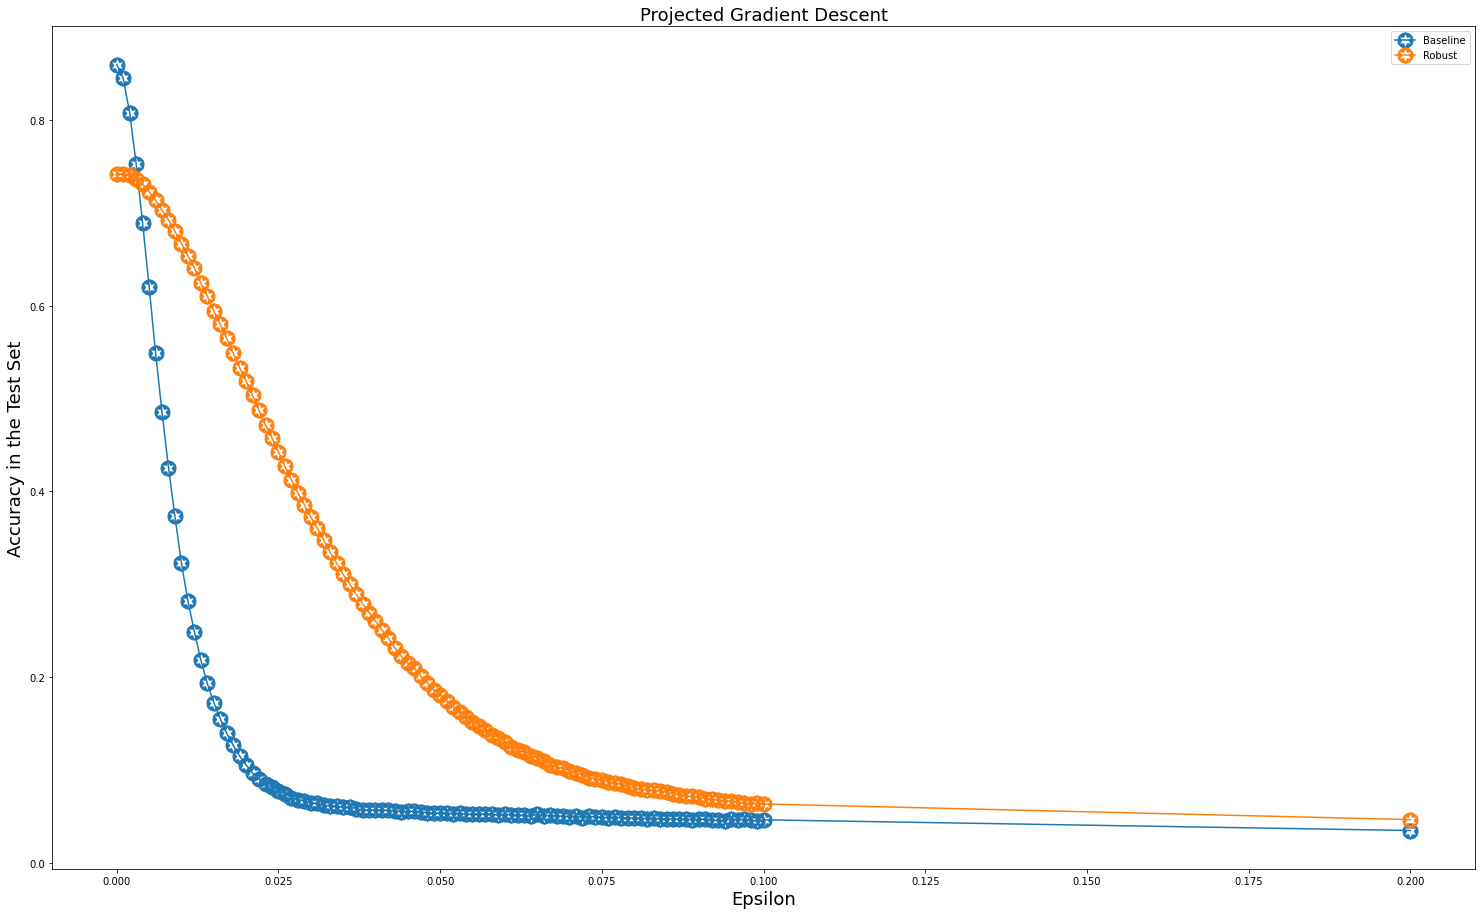

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , baseline , label='Baseline', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust , label='Robust', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent', fontsize=18)
plt.xlabel('Epsilon', fontsize=18);
plt.ylabel('Accuracy in the Test Set', fontsize=18);
plt.legend()
plt.show()

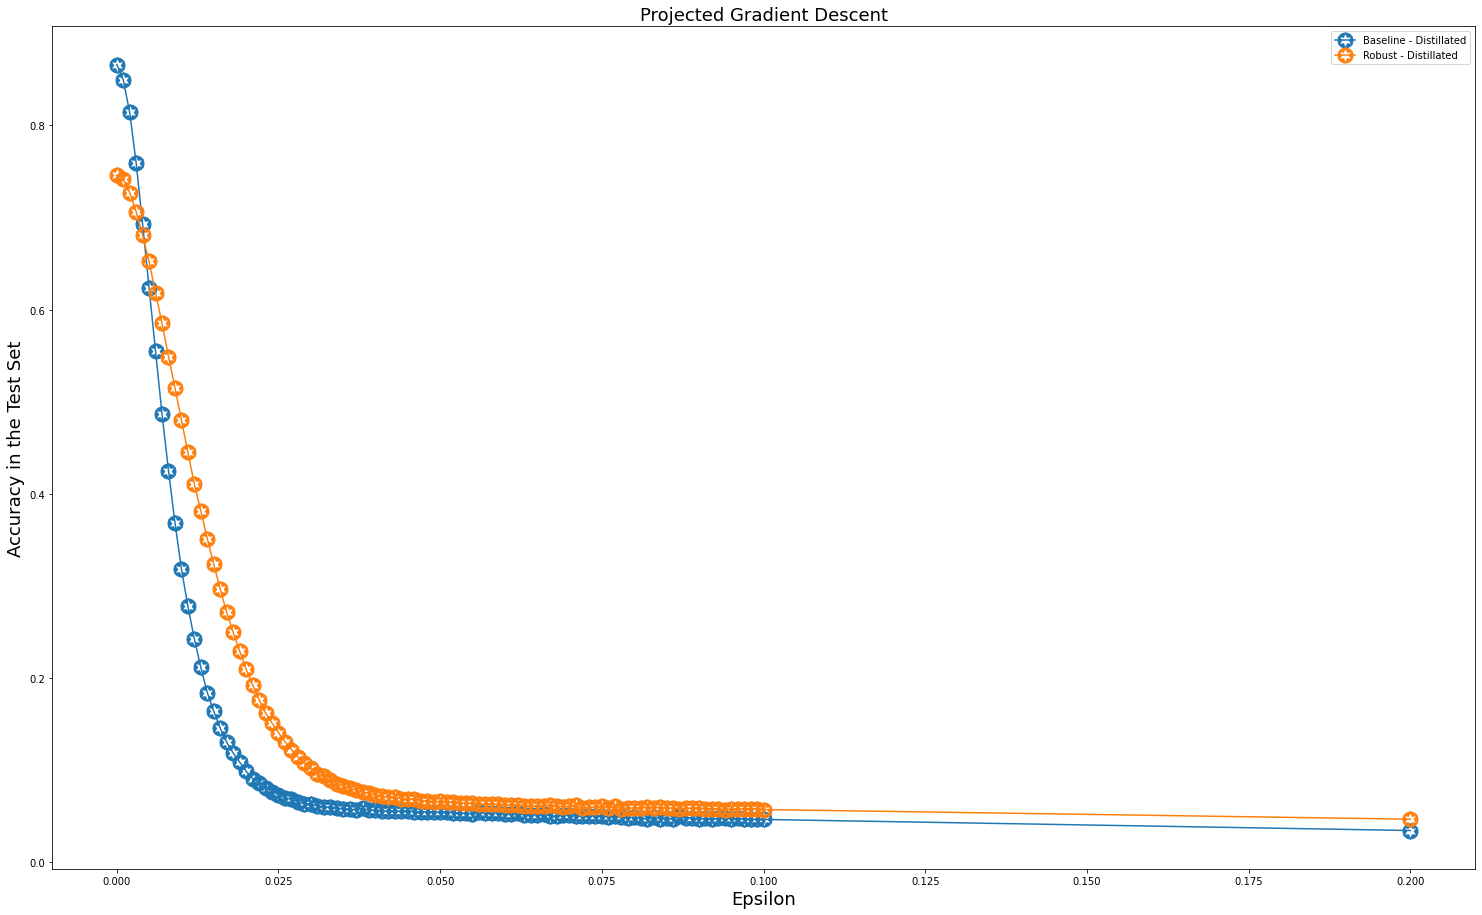

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , baseline_distill , label='Baseline - Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill , label='Robust - Distillated', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent', fontsize=18)
plt.xlabel('Epsilon', fontsize=18);
plt.ylabel('Accuracy in the Test Set', fontsize=18);
plt.legend()
plt.show()

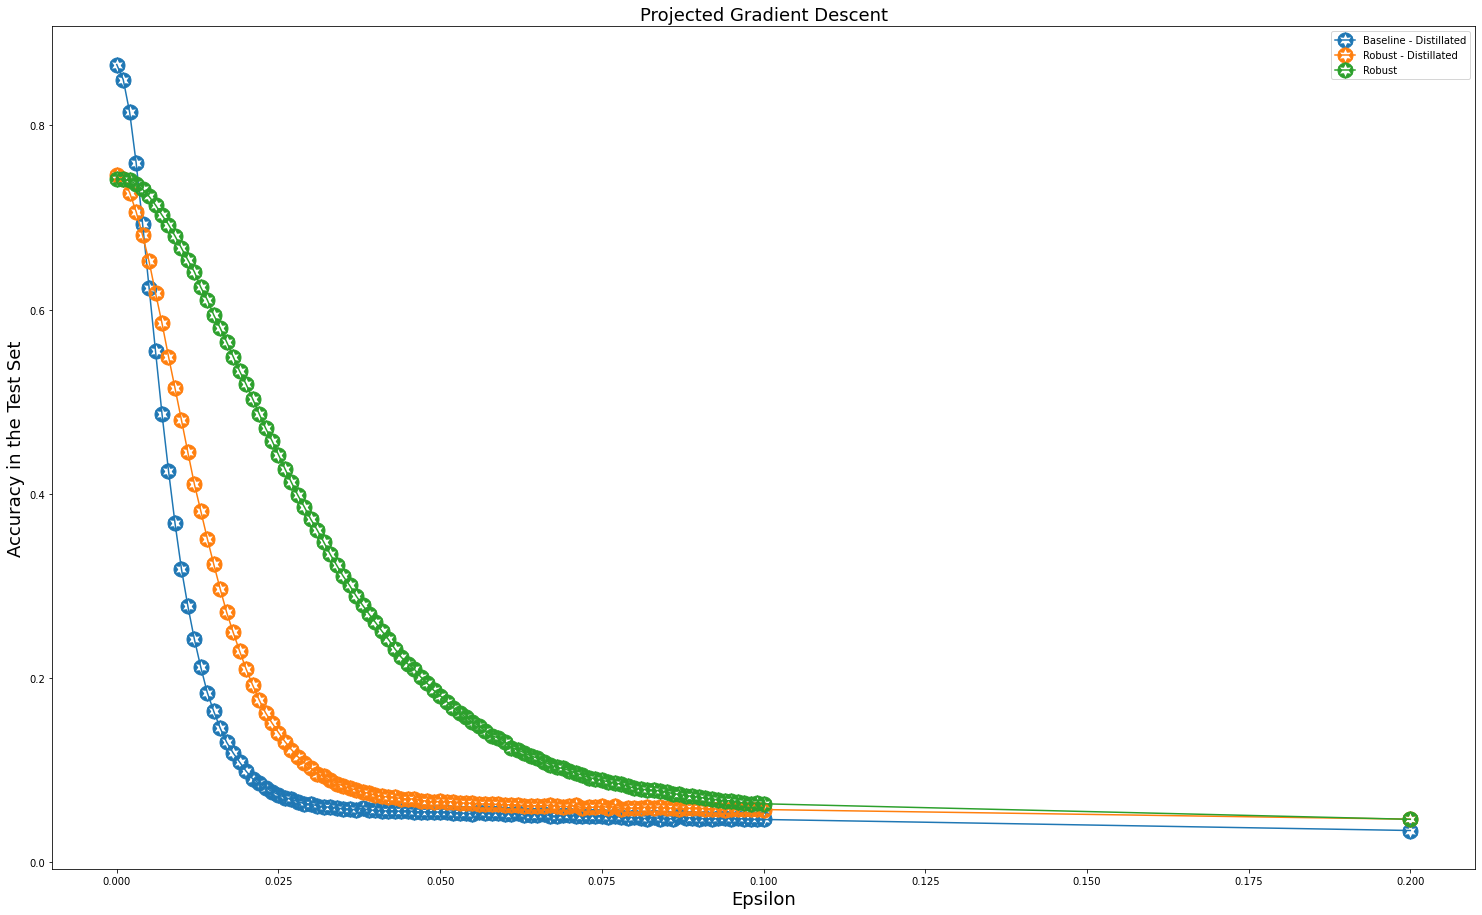

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , baseline_distill , label='Baseline - Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill , label='Robust - Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust , label='Robust', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent', fontsize=18)
plt.xlabel('Epsilon', fontsize=18);
plt.ylabel('Accuracy in the Test Set', fontsize=18);
plt.legend()
plt.show()

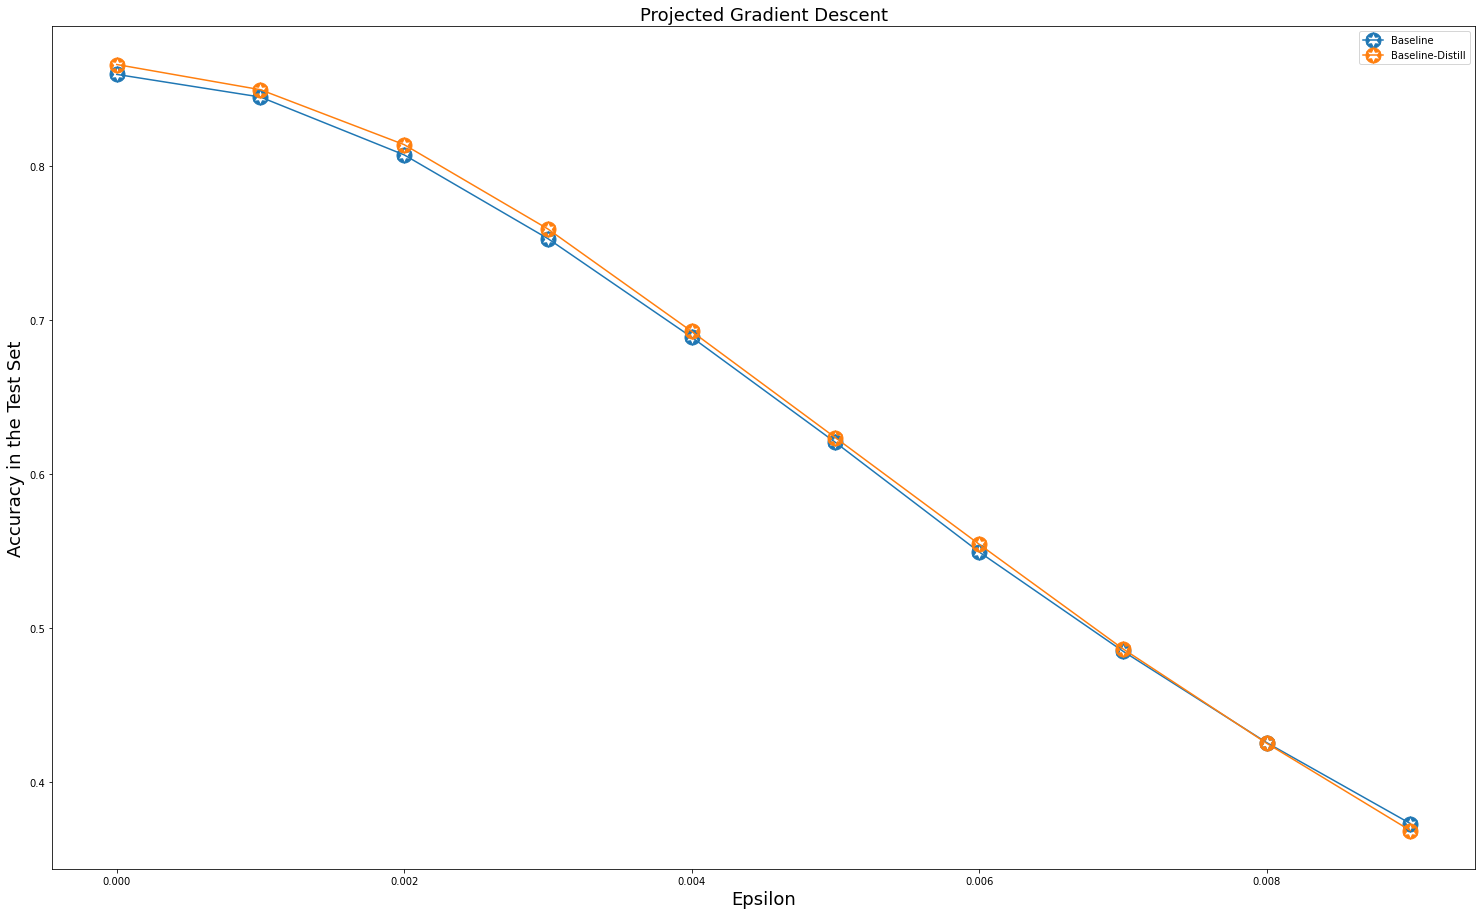

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values[:10] , baseline[:10] , label='Baseline', marker=cut_star, markersize=15)
plt.plot(epsilon_values[:10] , baseline_distill[:10] , label='Baseline-Distill', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent', fontsize=18)
plt.xlabel('Epsilon', fontsize=18);
plt.ylabel('Accuracy in the Test Set', fontsize=18);
plt.legend()
plt.show()

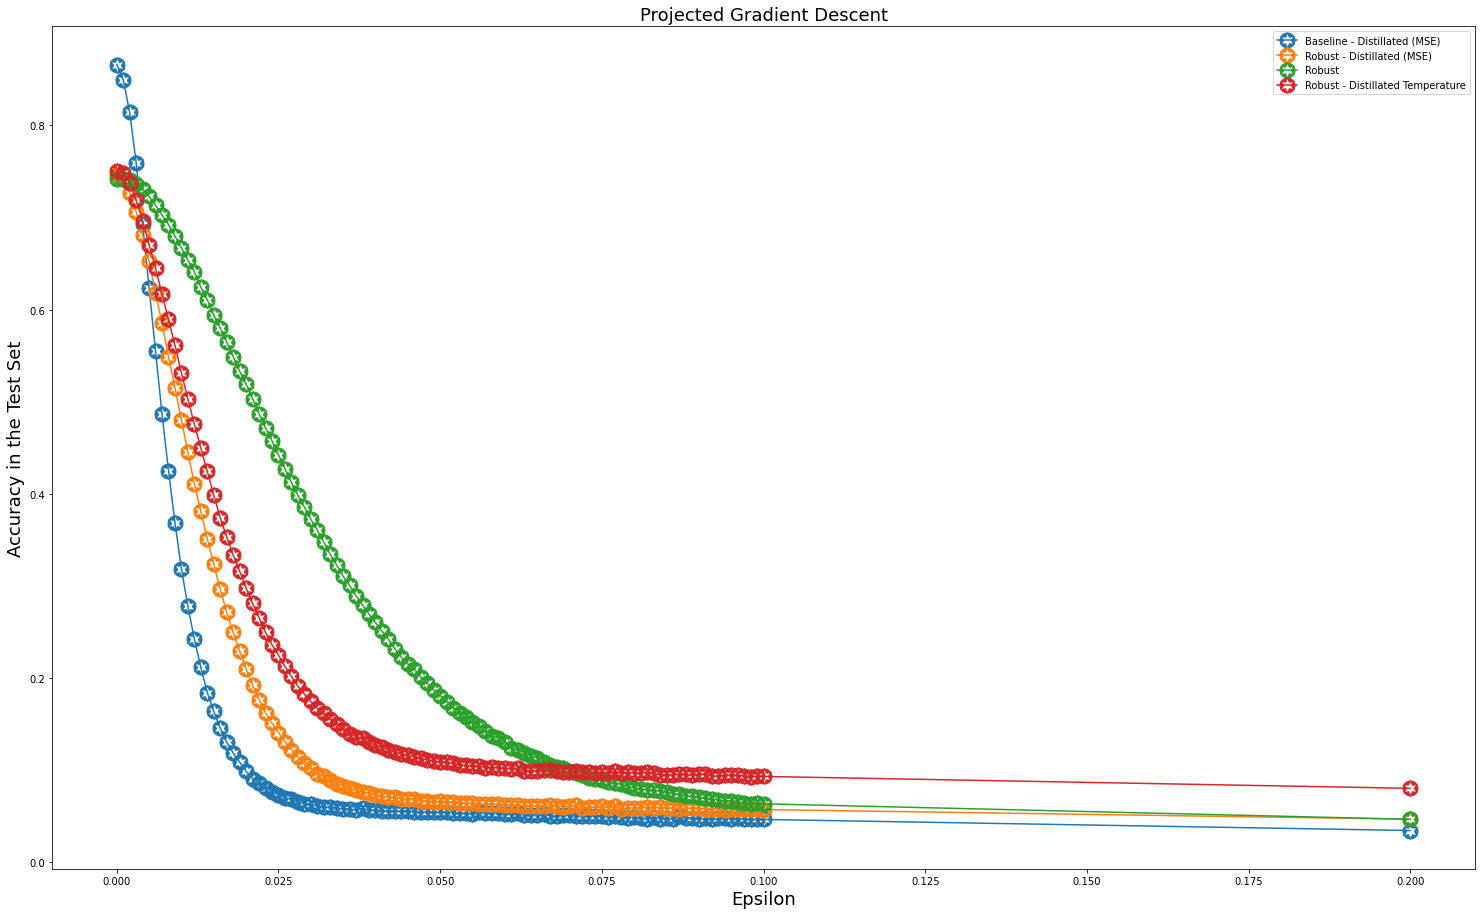

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , baseline_distill , label='Baseline - Distillated (MSE)', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill , label='Robust - Distillated (MSE)', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust , label='Robust', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill_temp_impr , label='Robust - Distillated Temperature', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent', fontsize=18)
plt.xlabel('Epsilon', fontsize=18);
plt.ylabel('Accuracy in the Test Set', fontsize=18);
plt.legend()
plt.show()

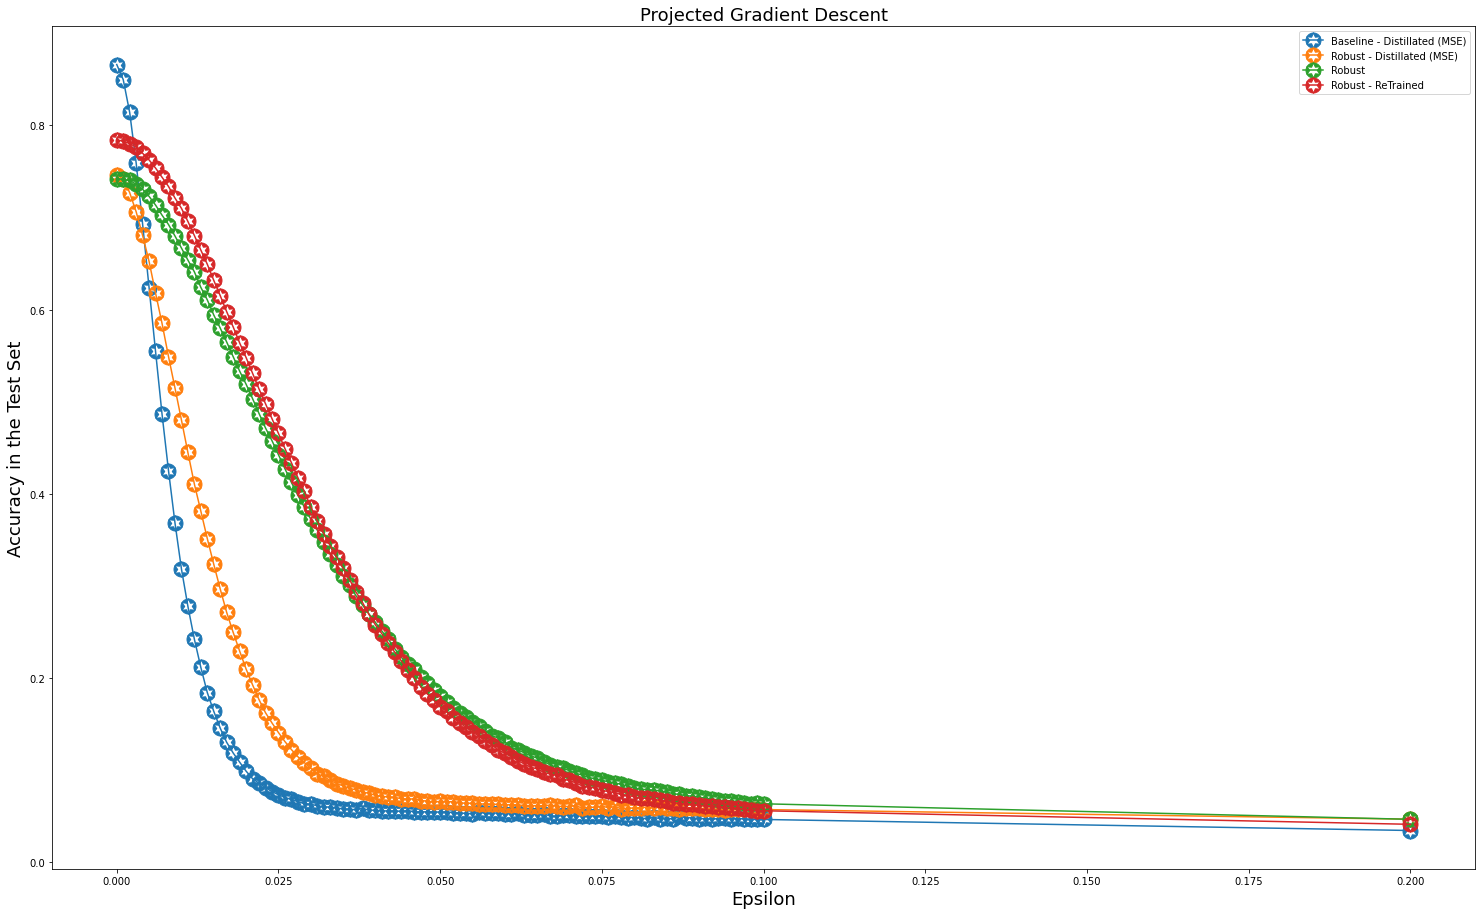

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , baseline_distill , label='Baseline - Distillated (MSE)', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill , label='Robust - Distillated (MSE)', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust , label='Robust', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill_retrained , label='Robust - ReTrained', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent', fontsize=18)
plt.xlabel('Epsilon', fontsize=18);
plt.ylabel('Accuracy in the Test Set', fontsize=18);
plt.legend()
plt.show()

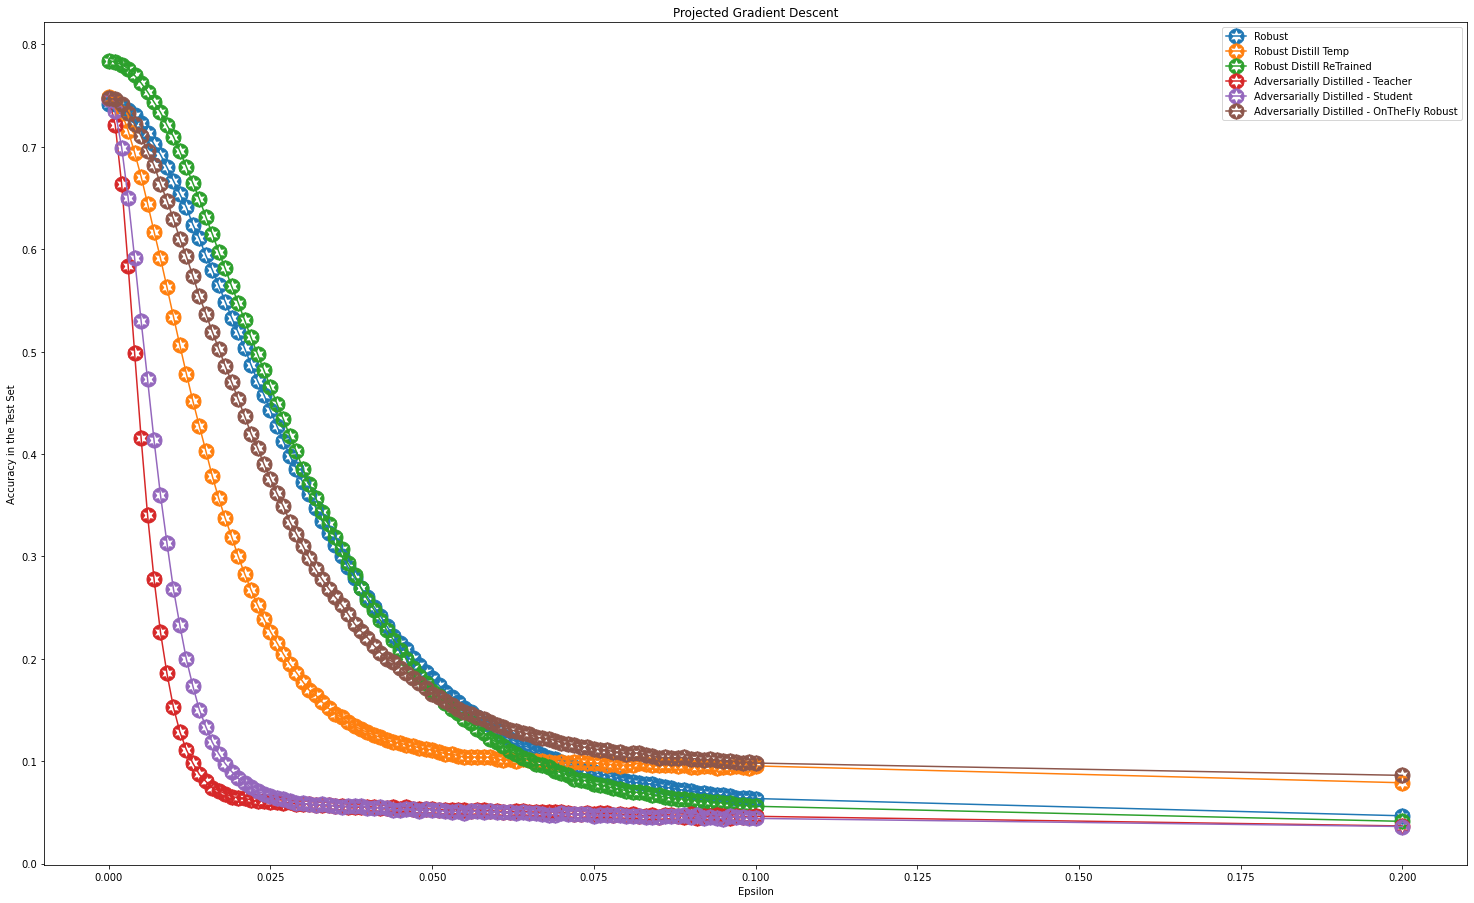

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , robust , label='Robust', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill_temp , label='Robust Distill Temp', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill_retrained , label='Robust Distill ReTrained', marker=cut_star, markersize=15)
plt.plot(epsilon_values , adv_distillated , label='Adversarially Distilled - Teacher', marker=cut_star, markersize=15)
plt.plot(epsilon_values , adv_distillated_student , label='Adversarially Distilled - Student', marker=cut_star, markersize=15)
plt.plot(epsilon_values , adv_74 , label='Adversarially Distilled - OnTheFly Robust', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

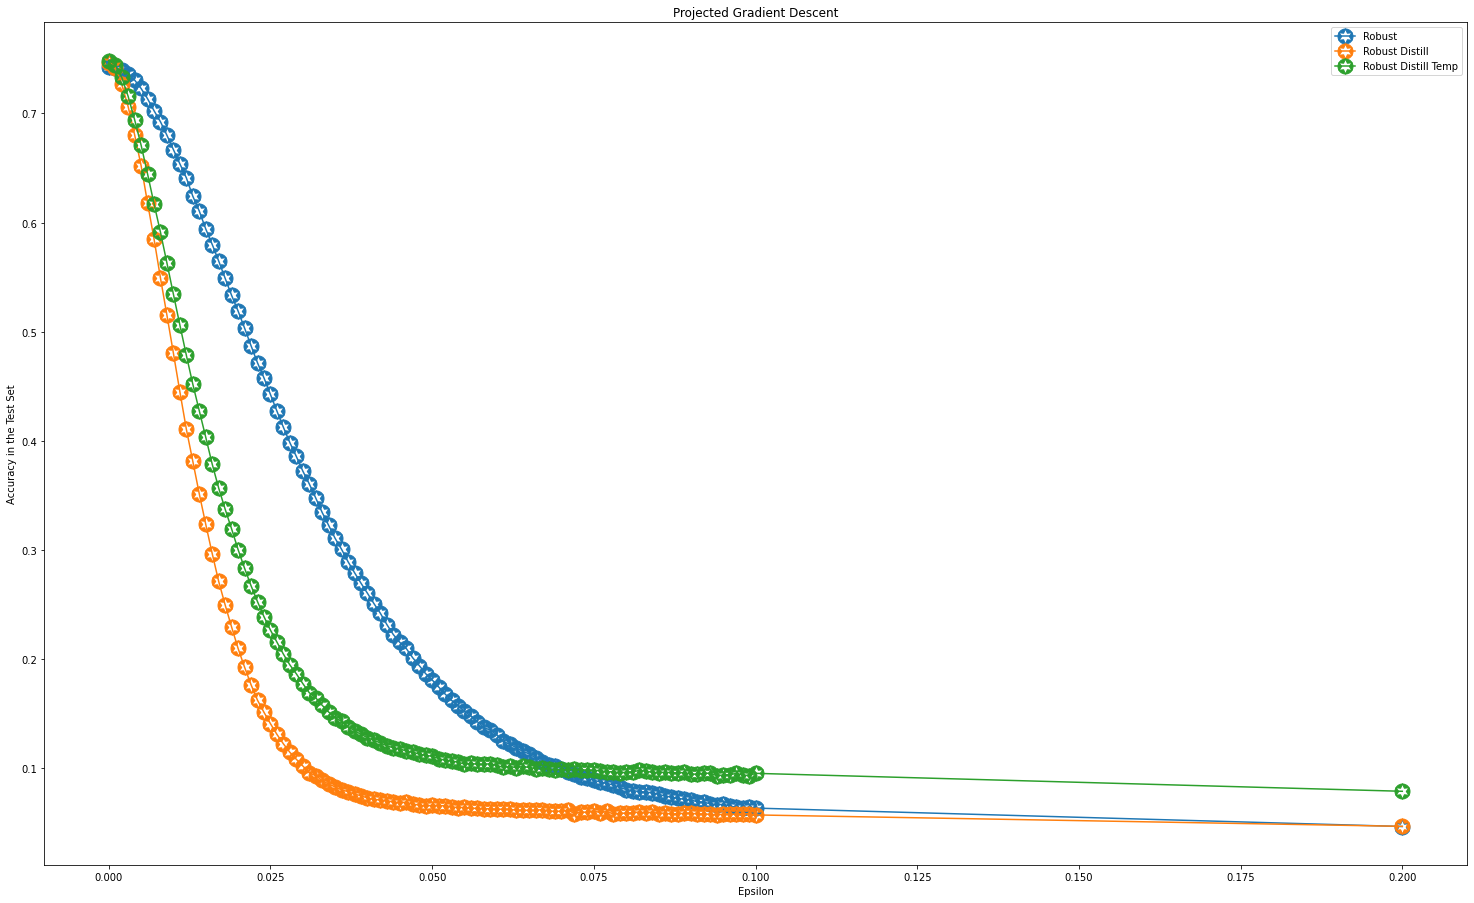

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , robust , label='Robust', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill , label='Robust Distill', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill_temp , label='Robust Distill Temp', marker=cut_star, markersize=15)


plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

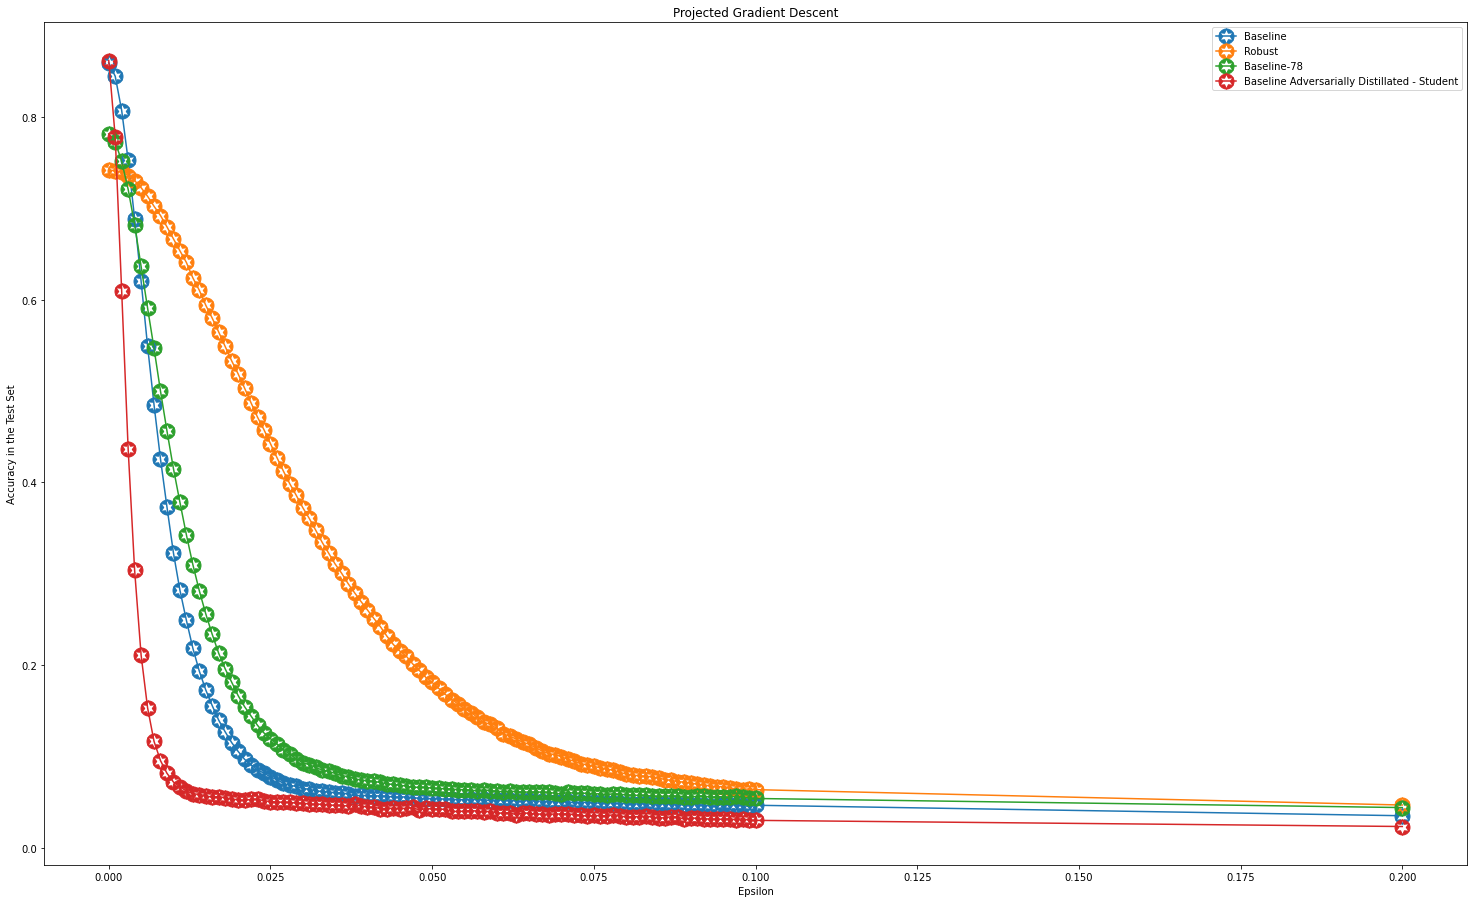

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , baseline , label='Baseline', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust , label='Robust', marker=cut_star, markersize=15)
plt.plot(epsilon_values , base78 , label='Baseline-78', marker=cut_star, markersize=15)
plt.plot(epsilon_values , adv_distillated_student_base , label='Baseline Adversarially Distillated - Student', marker=cut_star, markersize=15)


plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

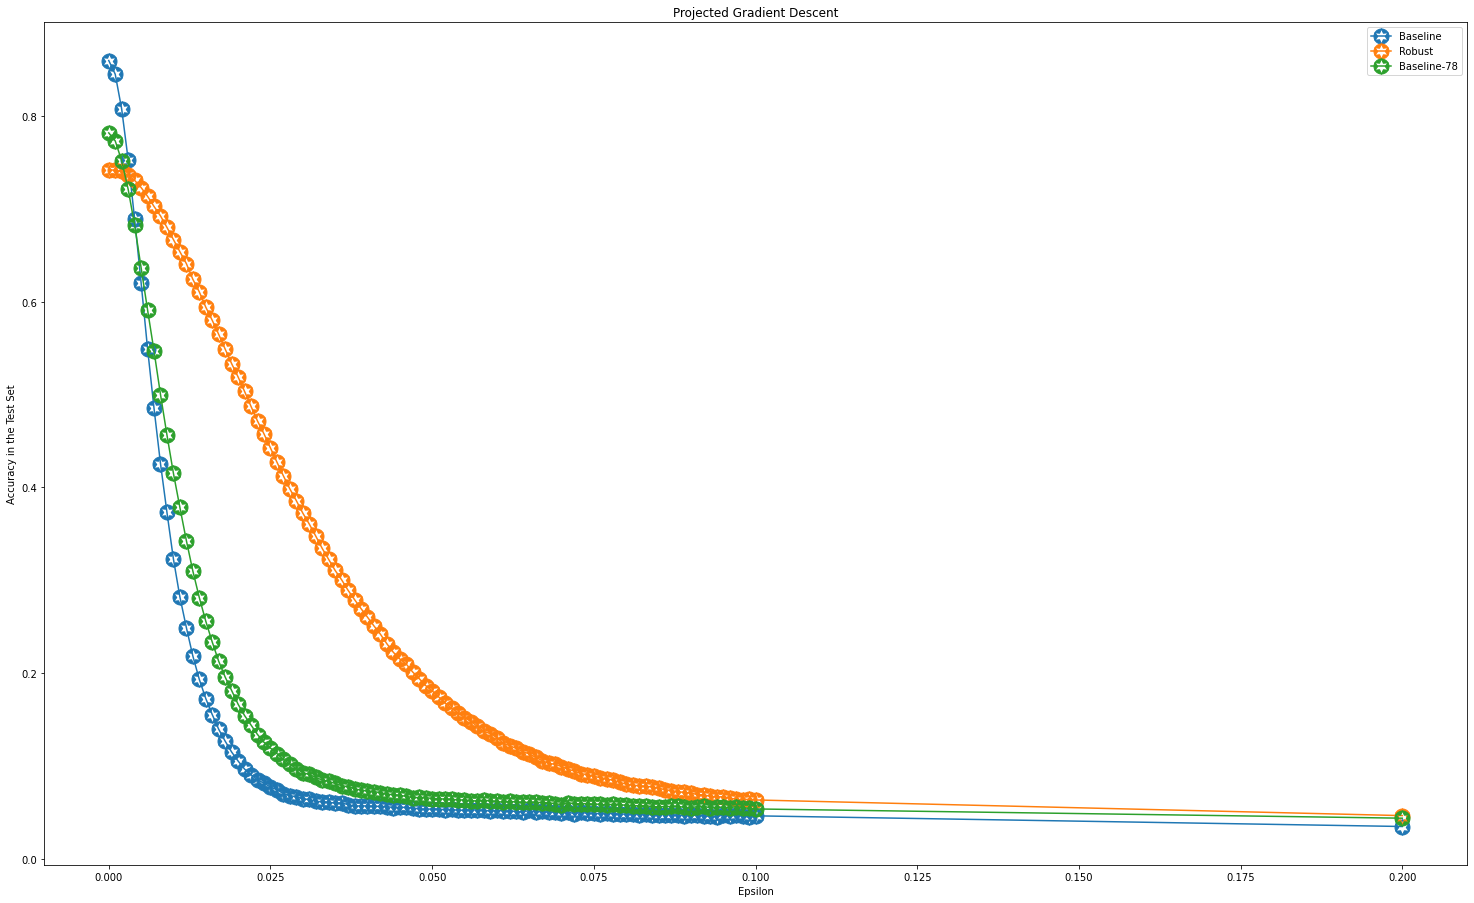

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , baseline , label='Baseline', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust , label='Robust', marker=cut_star, markersize=15)
plt.plot(epsilon_values , base78 , label='Baseline-78', marker=cut_star, markersize=15)


plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

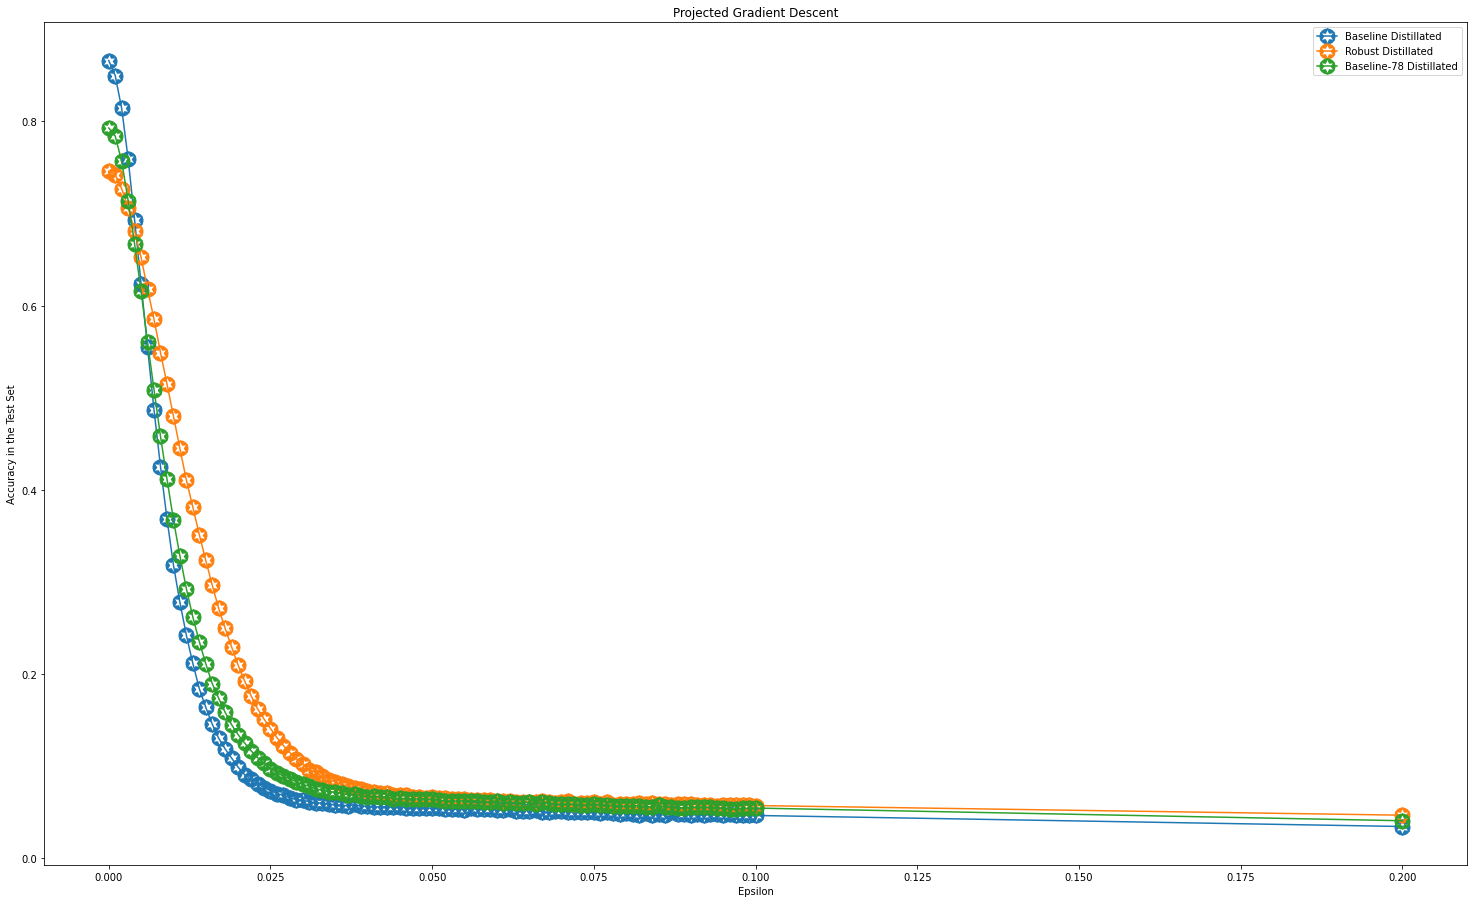

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , baseline_distill , label='Baseline Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill , label='Robust Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values , base78_distill , label='Baseline-78 Distillated', marker=cut_star, markersize=15)


plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

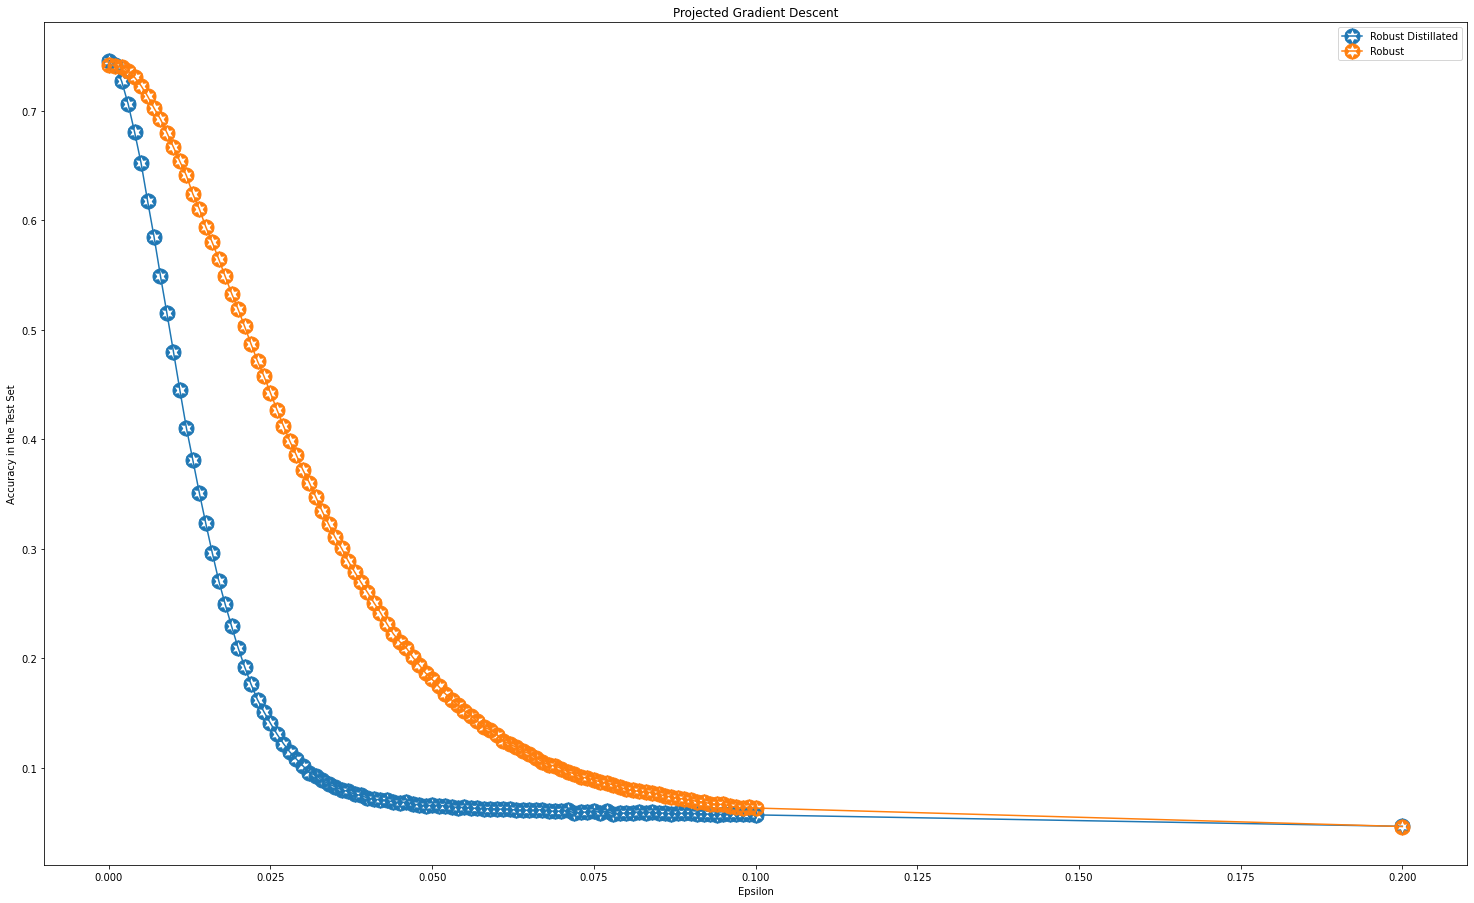

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , robust_distill , label='Robust Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust , label='Robust', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

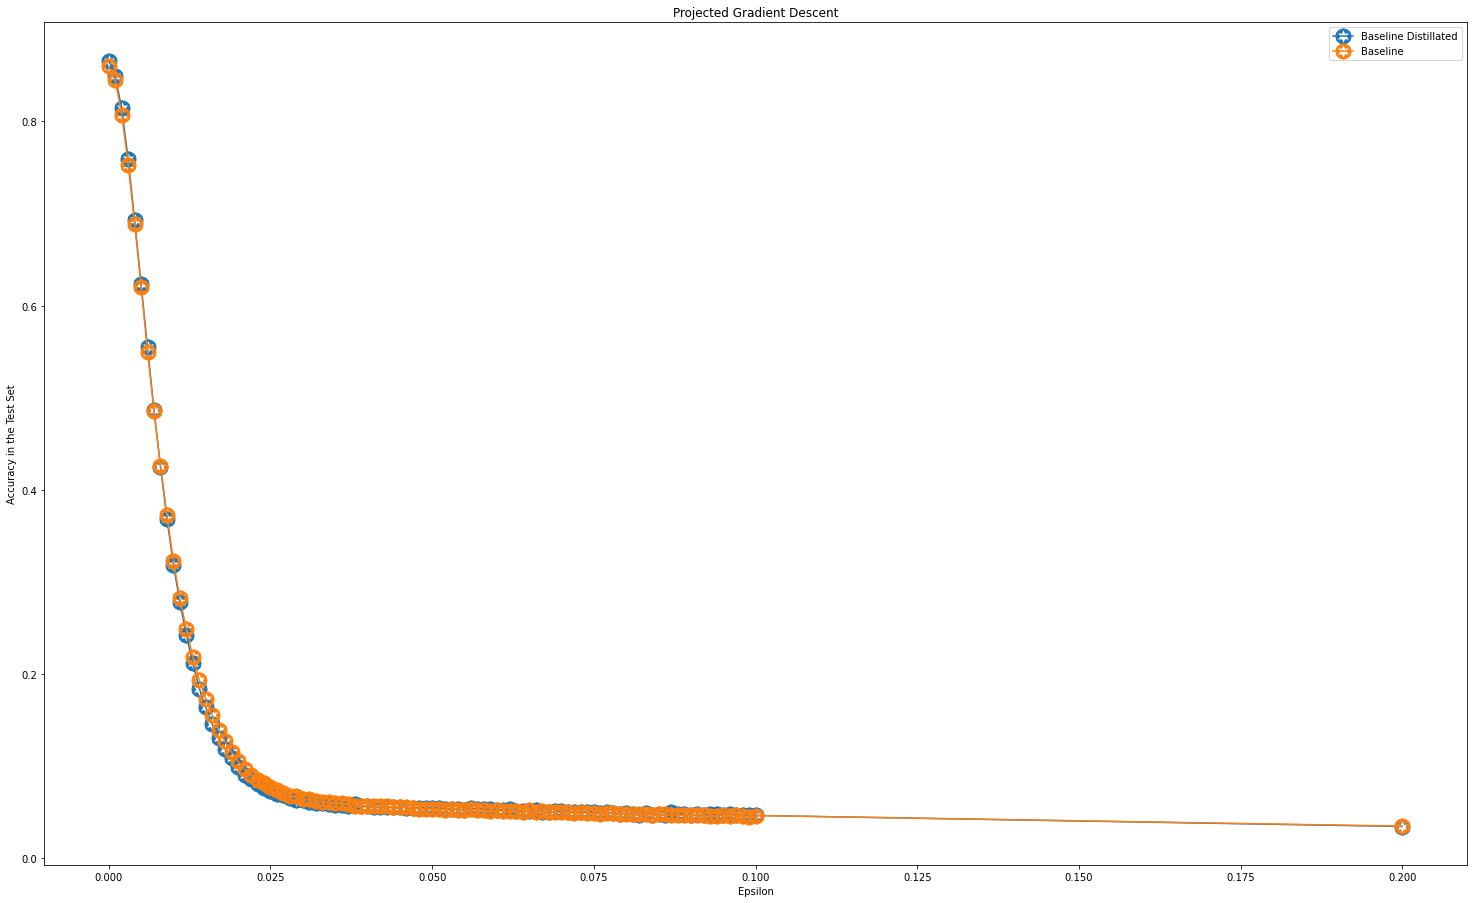

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , baseline_distill , label='Baseline Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values , baseline , label='Baseline', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

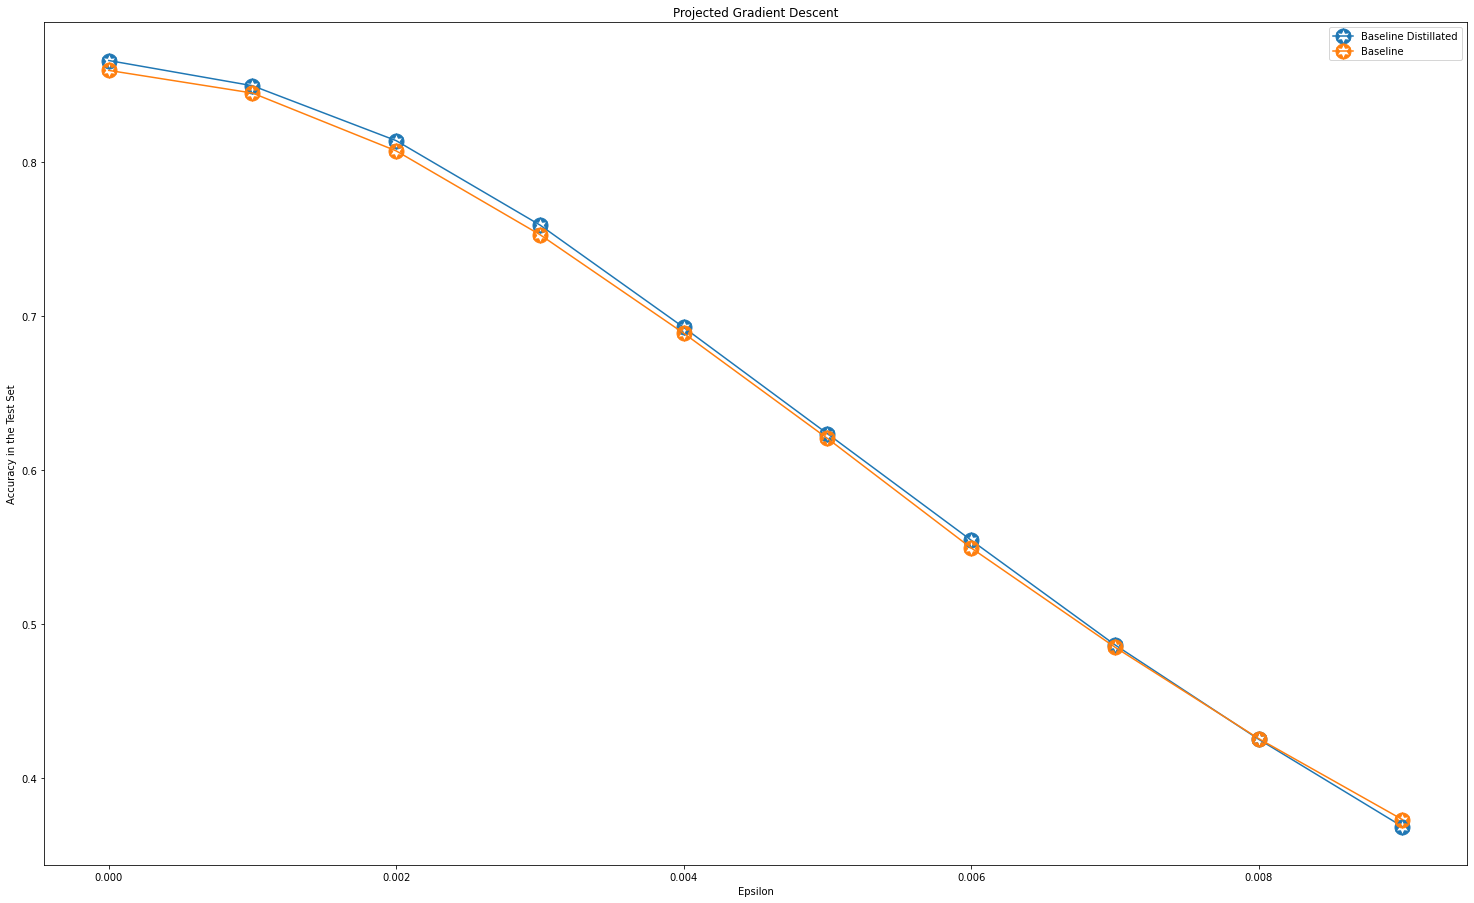

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values[:10] , baseline_distill[:10] , label='Baseline Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values[:10] , baseline[:10] , label='Baseline', marker=cut_star, markersize=15)

plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()

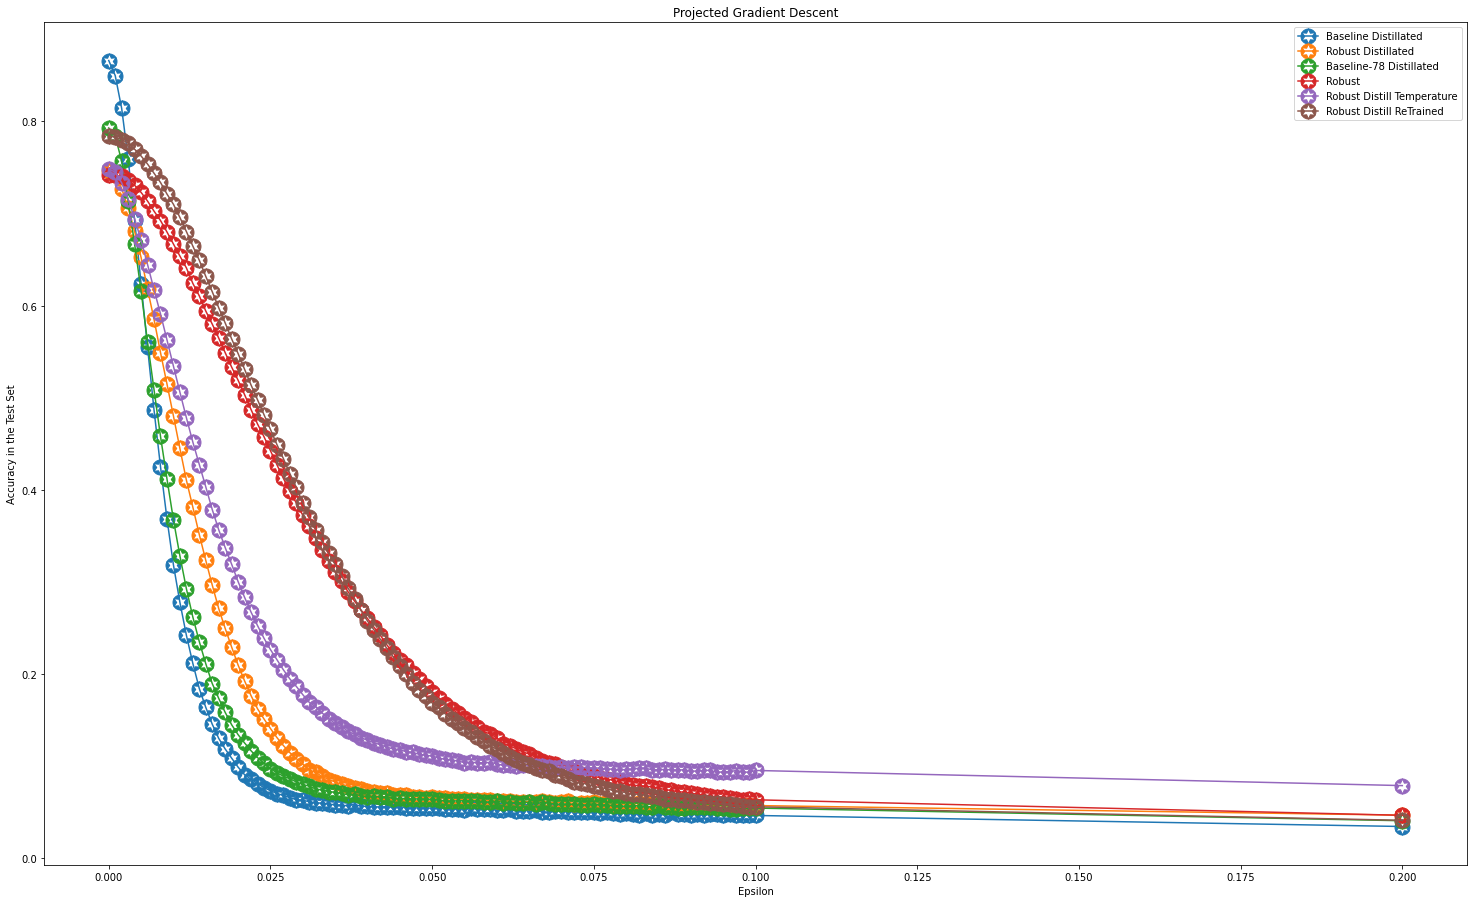

In [ ]:
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

fig = plt.figure()
fig.set_size_inches(25.5, 15.5)

plt.plot(epsilon_values , baseline_distill , label='Baseline Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill , label='Robust Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values , base78_distill , label='Baseline-78 Distillated', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust , label='Robust', marker=cut_star, markersize=15)
plt.plot(epsilon_values , robust_distill_temp , label='Robust Distill Temperature', marker=cut_star, markersize=15)
#plt.plot(epsilon_values , robust_distill_retrained , label='Robust Distill ReTrained', marker=cut_star, markersize=15)


plt.title('Projected Gradient Descent')
plt.xlabel('Epsilon');
plt.ylabel('Accuracy in the Test Set');
plt.legend()
plt.show()